# Assignment 1

In [2]:
import calendar
from datetime import datetime, timedelta

def get_nerc_holidays(year):
    holidays = []

    # Fixed date holidays
    holidays.append(datetime(year, 1, 1))  # New Year's Day
    holidays.append(datetime(year, 7, 4))  # Independence Day
    holidays.append(datetime(year, 12, 25))  # Christmas Day

    # Memorial Day (last Monday in May)
    last_may_day = datetime(year, 5, calendar.monthrange(year, 5)[1])
    while last_may_day.weekday() != 0:  # 0 is Monday
        last_may_day -= timedelta(days=1)
    holidays.append(last_may_day)

    # Labor Day (first Monday in September)
    first_september_day = datetime(year, 9, 1)
    while first_september_day.weekday() != 0:  # 0 is Monday
        first_september_day += timedelta(days=1)
    holidays.append(first_september_day)

    # Thanksgiving Day (fourth Thursday in November)
    fourth_november_day = datetime(year, 11, 1)
    thursday_count = 0
    while thursday_count < 4:
        if fourth_november_day.weekday() == 3:  # 3 is Thursday
            thursday_count += 1
        if thursday_count < 4:
            fourth_november_day += timedelta(days=1)
    holidays.append(fourth_november_day)

    return holidays

def is_nerc_holiday(date):
    return date in get_nerc_holidays(date.year)


def is_dst_start(date):
    return date.month == 3 and (7 <= date.day <= 14) and date.weekday() == 6

def is_dst_end(date):
    return date.month == 11 and (1 <= date.day <= 7) and date.weekday() == 6


def get_hours(iso, peak_type, period):
    # Parse period
    if period.endswith("A"):
        year = int(period[:-1])
        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31)
    elif period.endswith("Q"):
        year = int(period[:4])
        quarter = int(period[-1])
        start_month = (quarter - 1) * 3 + 1
        start_date = datetime(year, start_month, 1)
        end_date = datetime(year, start_month + 2, calendar.monthrange(year, start_month + 2)[1])
    elif period[-3:].isalpha():
        year = int(period[:4])
        month = datetime.strptime(period[4:], "%b").month
        start_date = datetime(year, month, 1)
        end_date = datetime(year, month, calendar.monthrange(year, month)[1])
    else:
        start_date = datetime.strptime(period, "%Y-%m-%d")
        end_date = start_date

    num_hours = 0
    current_date = start_date

    while current_date <= end_date:
        if peak_type.lower() == "onpeak":
            if current_date.weekday() < 5 and not is_nerc_holiday(current_date):
                num_hours += 16
        elif peak_type.lower() == "offpeak":
            if current_date.weekday() < 5 and not is_nerc_holiday(current_date):
                num_hours += 8
            else:
                num_hours += 24
        elif peak_type.lower() == "flat":
            num_hours += 24
        elif peak_type.lower() == "2x16h":
            if current_date.weekday() >= 5 or is_nerc_holiday(current_date):
                num_hours += 16
        elif peak_type.lower() == "7x8":
            num_hours += 8

        # DST adjustment
        if iso != "MISO" and is_dst_start(current_date):
            if peak_type.lower() in ["onpeak", "flat", "2x16h"]:
                num_hours -= 1
        elif iso != "MISO" and is_dst_end(current_date):
            if peak_type.lower() in ["onpeak", "flat", "2x16h"]:
                num_hours += 1

        current_date += timedelta(days=1)


    result = {
        'iso': iso,
        'peak_type': peak_type.upper(),
        'startdate': start_date.strftime("%Y-%m-%d"),
        'enddate': end_date.strftime("%Y-%m-%d"),
        'num_hours': num_hours
    }
    return result

# Sample Run
results = get_hours("MISO", "flat", "2019Mar")
print(results)  # Should output 744

results = get_hours("CAISO", "flat", "2019Mar")
print(results)  # Should output 743

results = get_hours("MISO", "flat", "2019Nov")
print(results)  # Should output 720

results = get_hours("CAISO", "flat", "2019Nov")
print(results)  # Should output 721


{'iso': 'MISO', 'peak_type': 'FLAT', 'startdate': '2019-03-01', 'enddate': '2019-03-31', 'num_hours': 744}
{'iso': 'CAISO', 'peak_type': 'FLAT', 'startdate': '2019-03-01', 'enddate': '2019-03-31', 'num_hours': 743}
{'iso': 'MISO', 'peak_type': 'FLAT', 'startdate': '2019-11-01', 'enddate': '2019-11-30', 'num_hours': 720}
{'iso': 'CAISO', 'peak_type': 'FLAT', 'startdate': '2019-11-01', 'enddate': '2019-11-30', 'num_hours': 721}


# Assignment 2

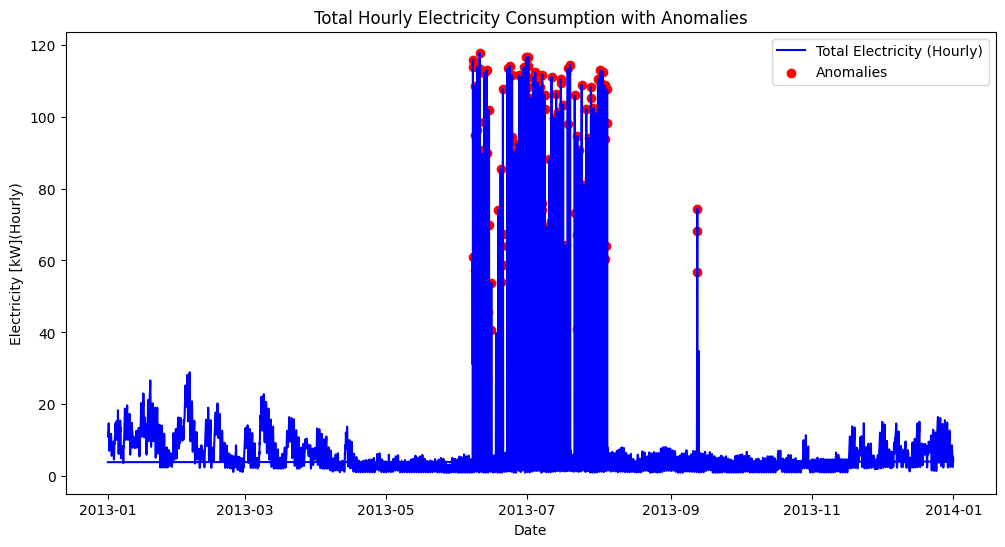

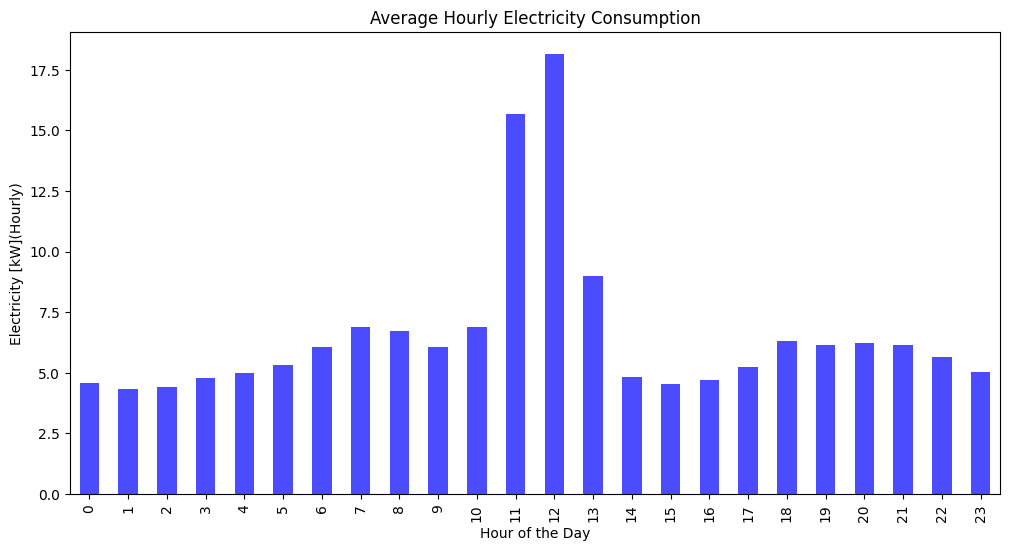

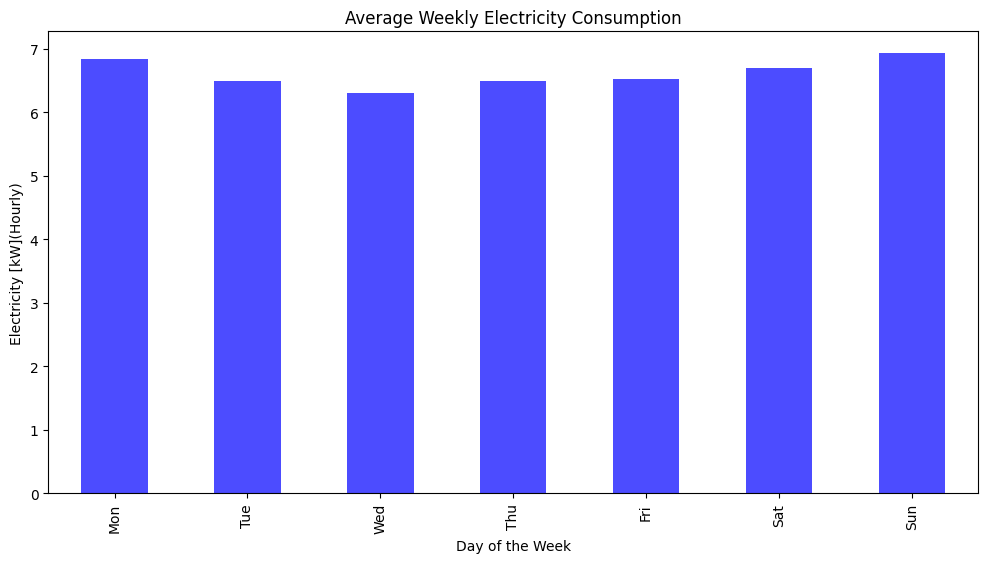

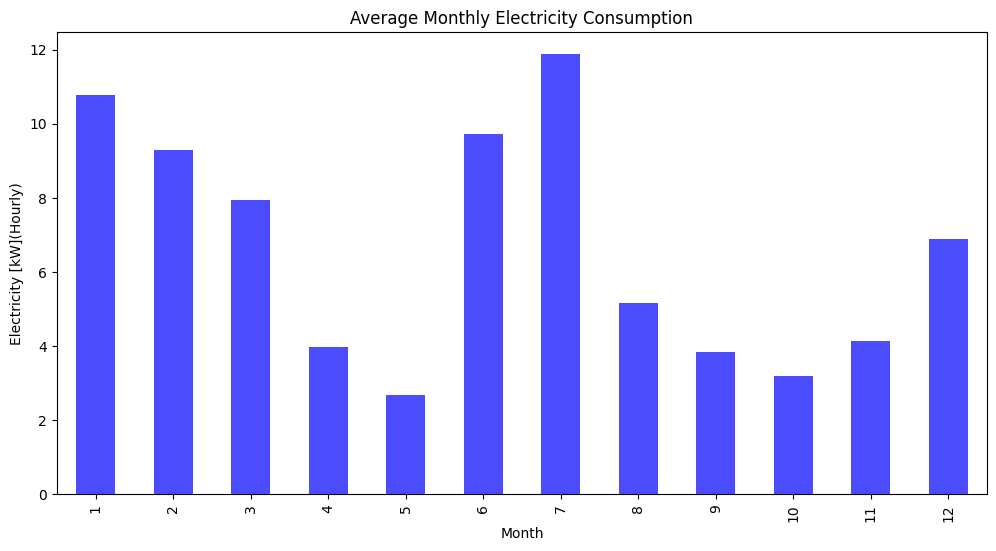

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from datetime import timedelta

# Load the data files
file1_path = r'/content/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv'
file2_path = r'/content/Assignment 2 - new.app4.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Drop the 'Unnamed: 0' column from df2
df2.drop('Unnamed: 0', axis=1, inplace=True)

# Remove leading/trailing spaces from the Date/Time column
df1['Date/Time'] = df1['Date/Time'].str.strip()

# Function to handle '24:00:00' case
def fix_24_hour_format(date_time_str):
    if '24:00:00' in date_time_str:
        date_time = pd.to_datetime(date_time_str.replace('24:00:00', '00:00:00'), format='%m/%d %H:%M:%S')
        return date_time + timedelta(days=1)
    return pd.to_datetime(date_time_str, format='%m/%d %H:%M:%S')

# Apply the function to fix the '24:00:00' issue
df1['Date/Time'] = df1['Date/Time'].apply(fix_24_hour_format)

# Convert the time columns to datetime format
df2['time'] = pd.to_datetime(df2['time'], format='%m/%d/%Y %H:%M')

# Extract the year from df2
df2_year = df2['time'].dt.year.mode()[0]

# Update the year in df1 to match the year in df2
df1['Date/Time'] = df1['Date/Time'].apply(lambda x: x.replace(year=df2_year))

# Set index to datetime for resampling
df2.set_index('time', inplace=True)

# Resample minute-by-minute data to hourly data
df2_hourly = df2.resample('H').sum()
df2_hourly = df2_hourly.rename(columns={'W_min': 'Electricity:Appliance [kW](Hourly)'})
df2_hourly['Electricity:Appliance [kW](Hourly)'] = df2_hourly['Electricity:Appliance [kW](Hourly)'] / 1000  # Convert watts to kilowatts

# Set index to datetime for merging
df1.set_index('Date/Time', inplace=True)

# Merge the datasets on df1's Date/Time
df_merged = pd.merge(df1, df2_hourly, left_index=True, right_index=True, how='left')


# Create a new column for total hourly consumption
df_merged['Total:Electricity [kW](Hourly)'] = df_merged.sum(axis=1)


# Output the merged data to a new CSV file
output_path = 'merged_electricity_data.csv'
df_merged.to_csv(output_path)

# Anomaly detection using Z-score
df_merged['Z-score'] = zscore(df_merged['Total:Electricity [kW](Hourly)'])

# Define a threshold for anomalies
threshold = 3

# Identify anomalies
df_anomalies = df_merged[df_merged['Z-score'].abs() > threshold]

# Plot anomalies for df_merged
plt.figure(figsize=(12, 6))
plt.plot(df_merged.index, df_merged['Total:Electricity [kW](Hourly)'], label='Total Electricity (Hourly)', color='blue')
plt.scatter(df_anomalies.index, df_anomalies['Total:Electricity [kW](Hourly)'], color='red', label='Anomalies')
plt.title('Total Hourly Electricity Consumption with Anomalies')
plt.xlabel('Date')
plt.ylabel('Electricity [kW](Hourly)')
plt.legend()
plt.show()

# Add Weekday column for grouping
df_merged['Weekday'] = df_merged.index.weekday

# Visualize patterns by hour, weekday, and month
# Hourly patterns
plt.figure(figsize=(12, 6))
df_merged.groupby(df_merged.index.hour)['Total:Electricity [kW](Hourly)'].mean().plot(kind='bar', color='blue', alpha=0.7)
plt.title('Average Hourly Electricity Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Electricity [kW](Hourly)')
plt.show()

# Weekly patterns
plt.figure(figsize=(12, 6))
df_merged.groupby('Weekday')['Total:Electricity [kW](Hourly)'].mean().plot(kind='bar', color='blue', alpha=0.7)
plt.title('Average Weekly Electricity Consumption')
plt.xlabel('Day of the Week')
plt.ylabel('Electricity [kW](Hourly)')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Monthly patterns
plt.figure(figsize=(12, 6))
df_merged.groupby(df_merged.index.month)['Total:Electricity [kW](Hourly)'].mean().plot(kind='bar', color='blue', alpha=0.7)
plt.title('Average Monthly Electricity Consumption')
plt.xlabel('Month')
plt.ylabel('Electricity [kW](Hourly)')
plt.show()


# Assignment 3

## Exploration data analysis

### Data visualization

In [ ]:
import pandas as pd

# Load the data from the provided Excel file
file_path = '/content/Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the data to understand its structure
df.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,1,2017-01-01,OFFPEAK,JANUARY,2017
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,2,2017-01-01,OFFPEAK,JANUARY,2017
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,3,2017-01-01,OFFPEAK,JANUARY,2017
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,4,2017-01-01,OFFPEAK,JANUARY,2017
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,5,2017-01-01,OFFPEAK,JANUARY,2017


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   DATETIME                     14987 non-null  datetime64[ns]
 1   HB_NORTH (RTLMP)             14987 non-null  float64       
 2   ERCOT (WIND_RTI)             14982 non-null  float64       
 3   ERCOT (GENERATION_SOLAR_RT)  14983 non-null  float64       
 4   ERCOT (RTLOAD)               14987 non-null  float64       
 5   HOURENDING                   14987 non-null  int64         
 6   MARKETDAY                    14987 non-null  datetime64[ns]
 7   PEAKTYPE                     14987 non-null  object        
 8   MONTH                        14987 non-null  object        
 9   YEAR                         14987 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 1.1+ MB


Handling Missing Values

In [ ]:
# Checking for missing values
missing_values = df.isnull().sum()

# Replace missing values with 0
df_filled = df.fillna(0)

missing_values_after = df_filled.isnull().sum()

missing_values, missing_values_after


(DATETIME                       0
 HB_NORTH (RTLMP)               0
 ERCOT (WIND_RTI)               5
 ERCOT (GENERATION_SOLAR_RT)    4
 ERCOT (RTLOAD)                 0
 HOURENDING                     0
 MARKETDAY                      0
 PEAKTYPE                       0
 MONTH                          0
 YEAR                           0
 dtype: int64,
 DATETIME                       0
 HB_NORTH (RTLMP)               0
 ERCOT (WIND_RTI)               0
 ERCOT (GENERATION_SOLAR_RT)    0
 ERCOT (RTLOAD)                 0
 HOURENDING                     0
 MARKETDAY                      0
 PEAKTYPE                       0
 MONTH                          0
 YEAR                           0
 dtype: int64)

In [ ]:
df_filled.describe()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,YEAR
count,14987,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987,14987.000000
mean,2017-11-09 06:41:09.340094720,25.766417,7529.923293,291.911783,42371.673703,12.495763,2017-11-08 18:11:24.593314304,2017.415493
min,2017-01-01 01:00:00,-17.860000,0.000000,0.000000,25566.511248,1.000000,2017-01-01 00:00:00,2017.000000
25%,2017-06-06 04:30:00,18.041250,4133.925000,0.000000,35431.636526,6.000000,2017-06-06 00:00:00,2017.000000
50%,2017-11-09 06:00:00,20.057500,7278.960000,21.930000,39934.007113,12.000000,2017-11-09 00:00:00,2017.000000
75%,2018-04-14 09:30:00,25.030000,10851.280000,608.580000,47873.100786,18.000000,2018-04-14 00:00:00,2018.000000
max,2018-09-17 12:00:00,2809.357500,20350.400000,1257.540000,73264.662123,24.000000,2018-09-17 00:00:00,2018.000000
std,NaN,46.361945,3994.588069,370.895763,9874.339631,6.922309,NaN,0.492823


The standard deviation is two times higher than the mean, which means a skewed distribution, which can affect the assumptions of many statistical and machine learning models that assume normally distributed data.

### Handle negative price

delete all the negative values

In [ ]:
import pandas as pd

datetime_column = 'DATETIME'

# Select only numerical columns, excluding the datetime column
numerical_columns = df_filled.select_dtypes(include=['number']).columns

# Calculate the number of negative values in the numerical columns
negative_value_count = (df_filled[numerical_columns] < 0).sum().sum()
print(f"Number of negative values: {negative_value_count}")

# Delete rows containing negative values in the numerical columns
df_filled = df_filled[(df_filled[numerical_columns] >= 0).all(axis=1)]

# Optionally, reset the index if you want a clean DataFrame after deletion
df_filled.reset_index(drop=True, inplace=True)

Number of negative values: 75


## Visualization

### Time Series Plot

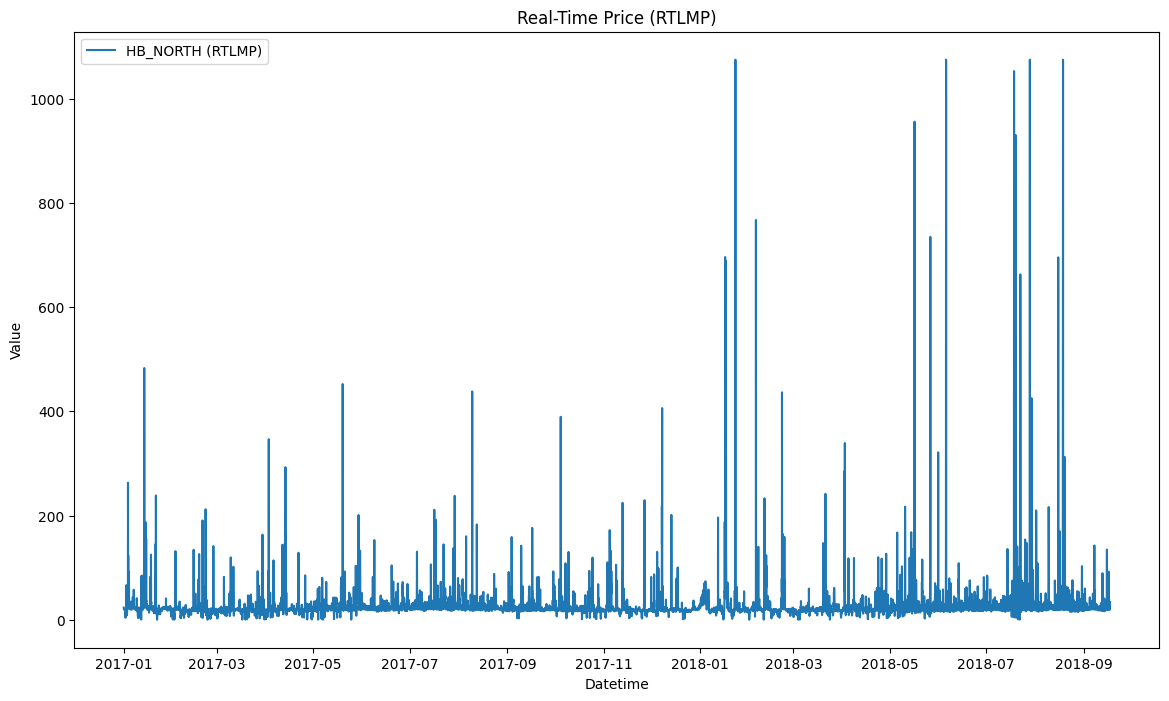

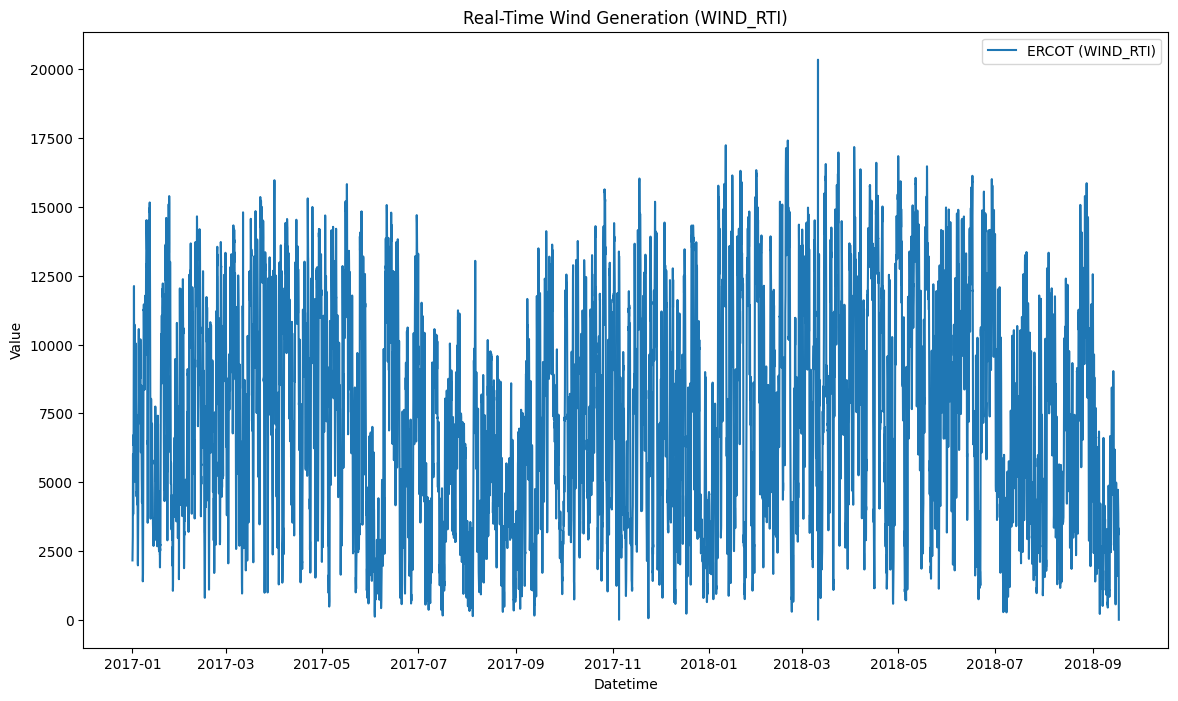

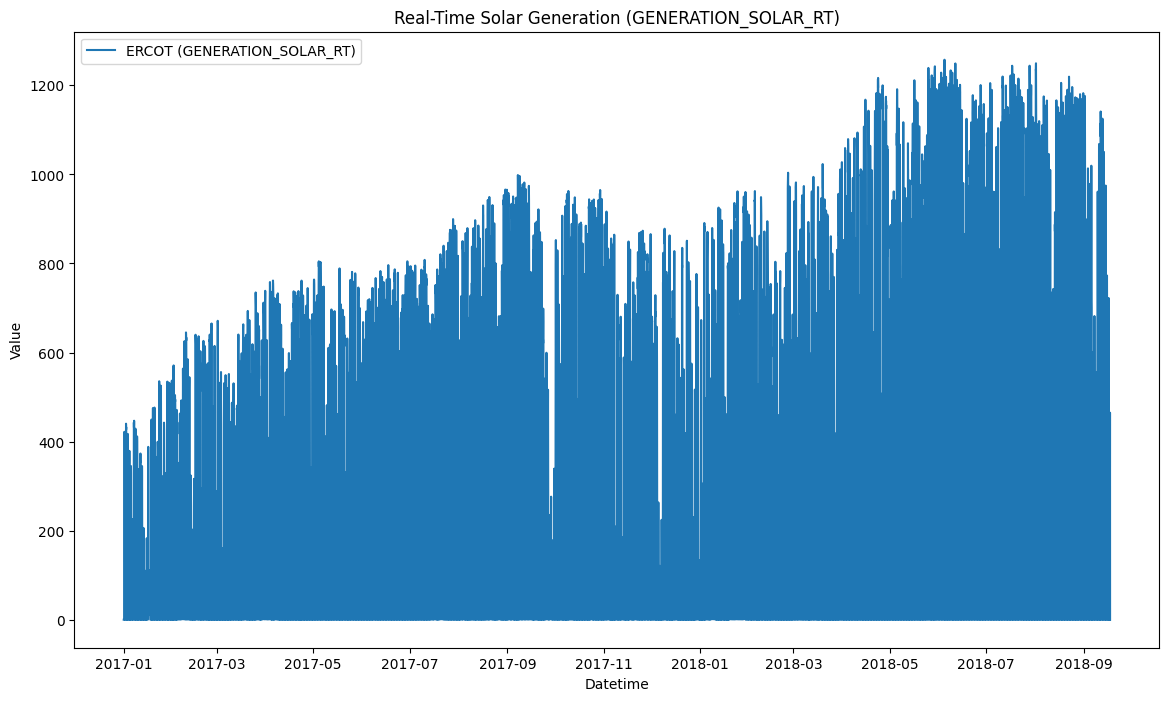

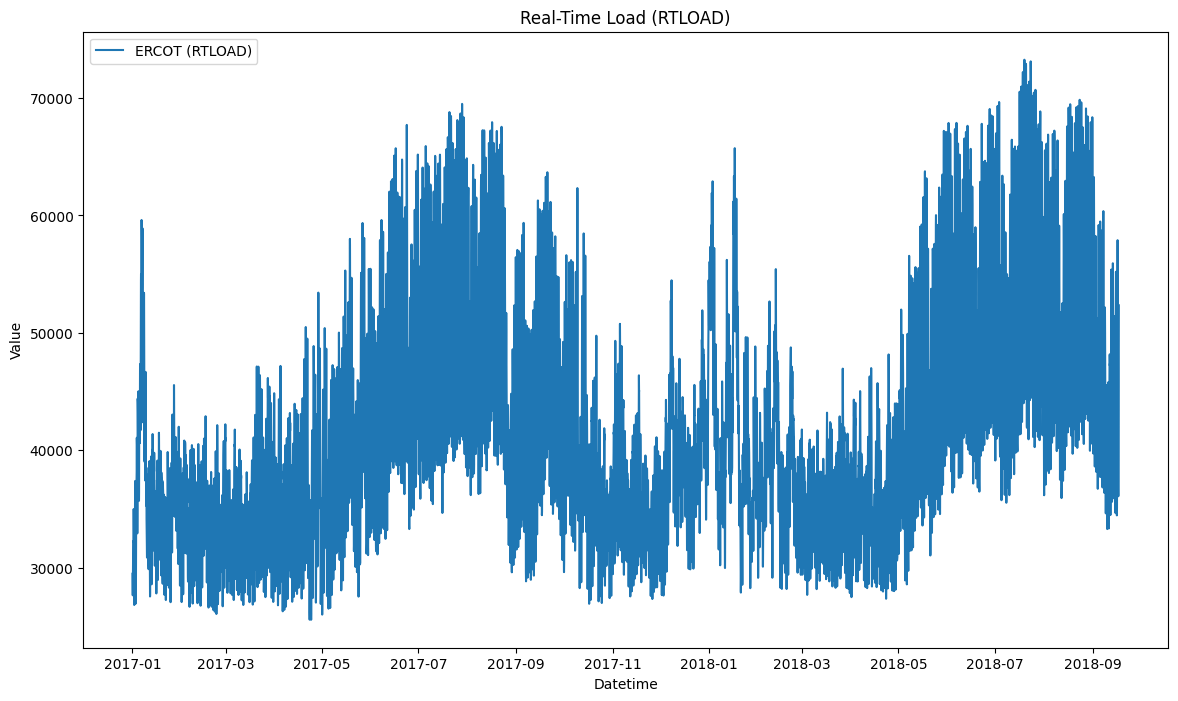

In [ ]:
import matplotlib.pyplot as plt

# Plotting function for time series data
def plot_time_series(df, column, title):
    plt.figure(figsize=(14, 8))
    plt.plot(df['DATETIME'], df[column], label=column)
    plt.xlabel('Datetime')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

# Columns to visualize
columns_to_visualize = {
    'HB_NORTH (RTLMP)': 'Real-Time Price (RTLMP)',
    'ERCOT (WIND_RTI)': 'Real-Time Wind Generation (WIND_RTI)',
    'ERCOT (GENERATION_SOLAR_RT)': 'Real-Time Solar Generation (GENERATION_SOLAR_RT)',
    'ERCOT (RTLOAD)': 'Real-Time Load (RTLOAD)'
}

# Plot each column
for column, title in columns_to_visualize.items():
    plot_time_series(df_filled, column, title)


### Seasonal analysis

Categorize the data into four seasons:

Winter (December, January, February)
Spring (March, April, May)
Summer (June, July, August)
Fall (September, October, November)
We will then plot the average values of each parameter for these seasons.

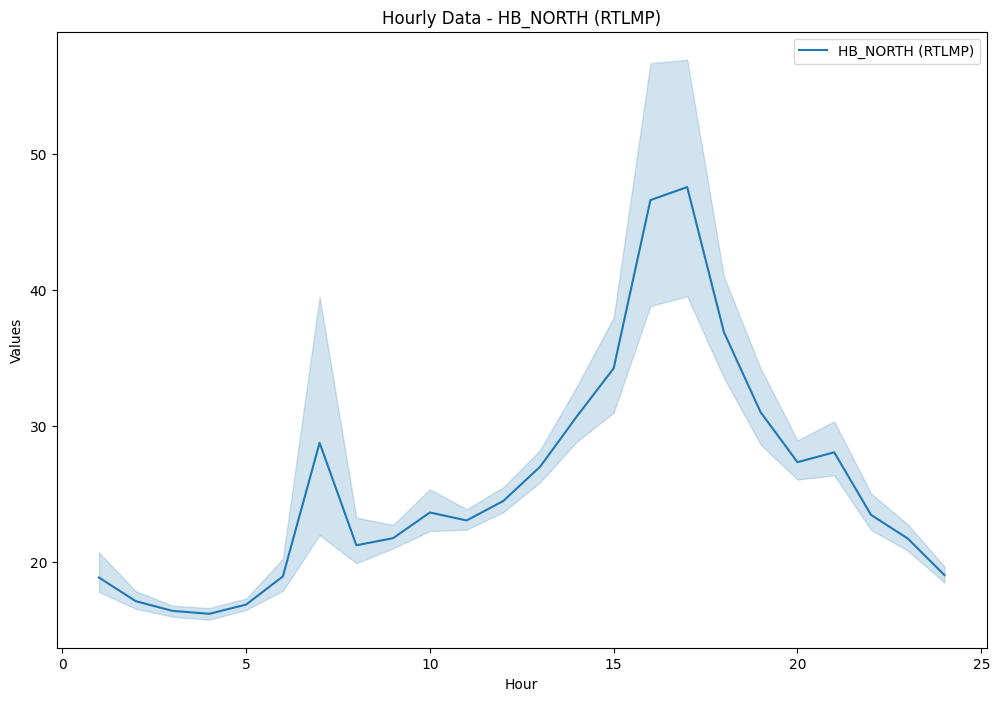

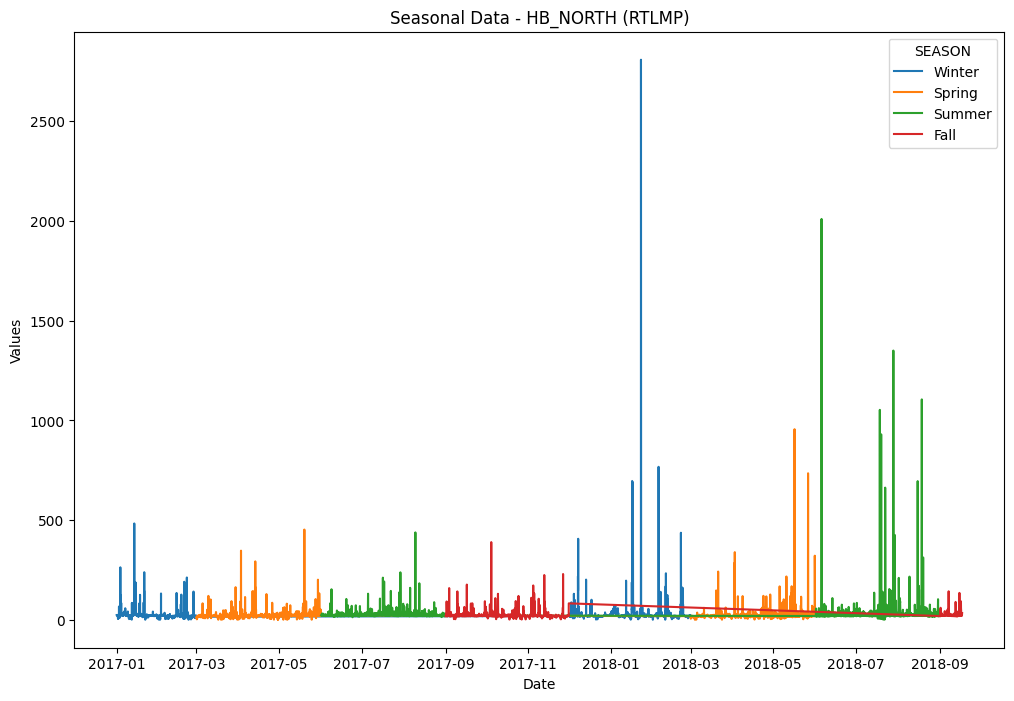

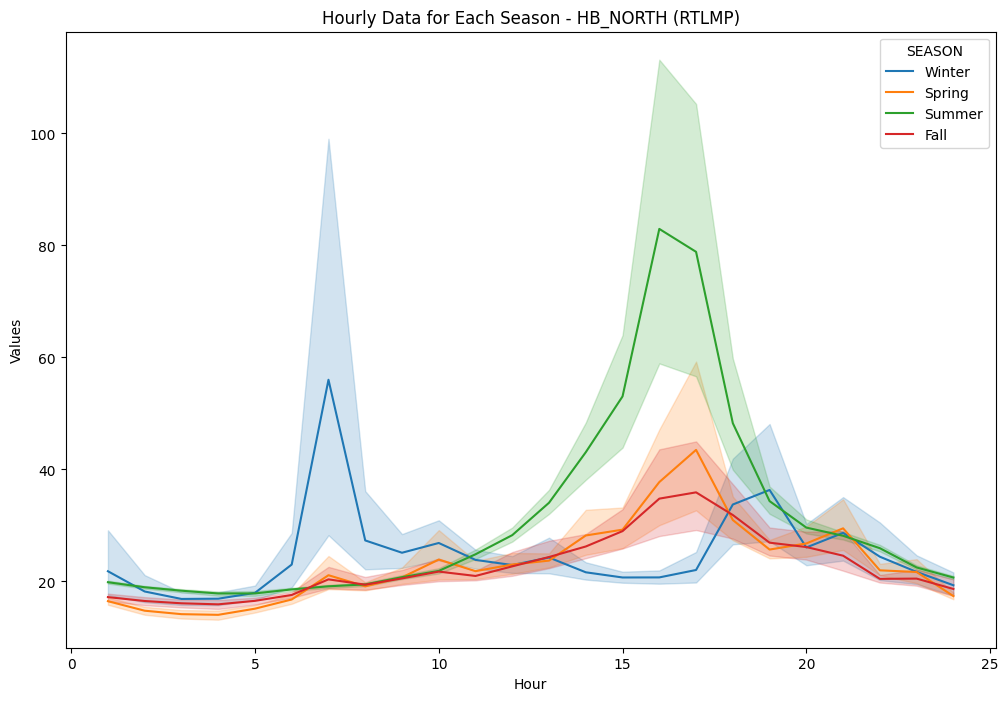

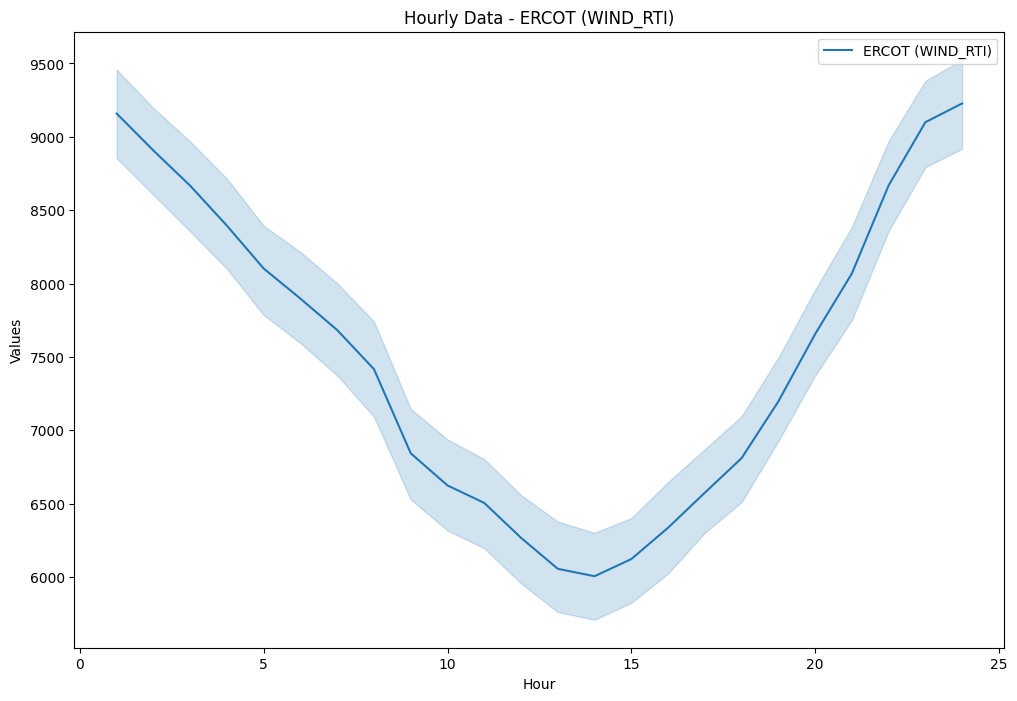

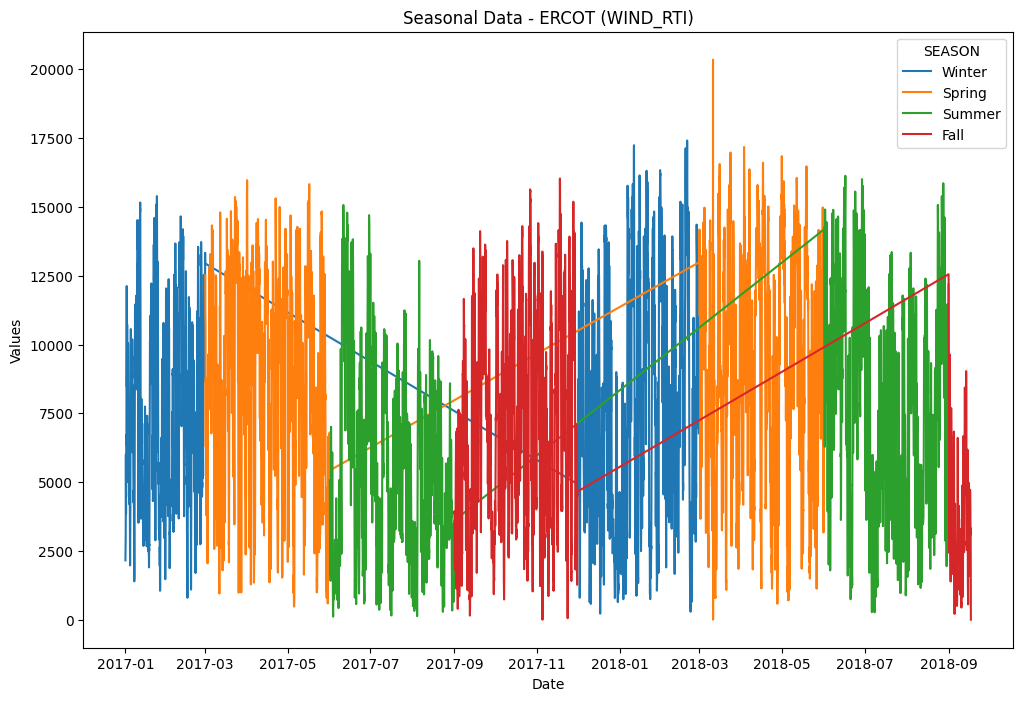

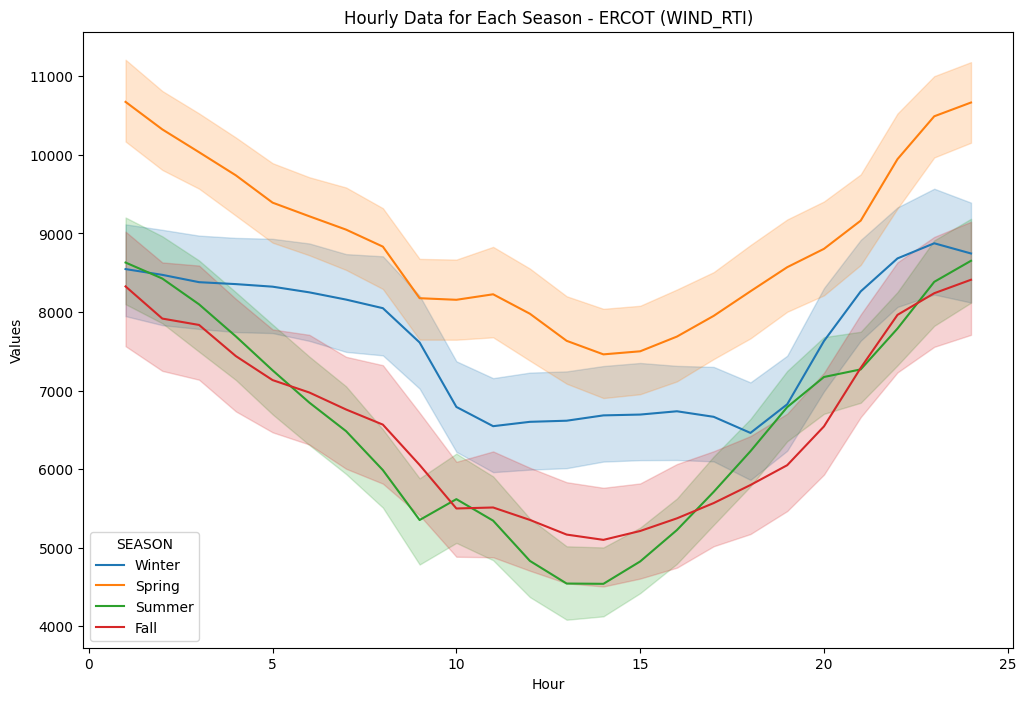

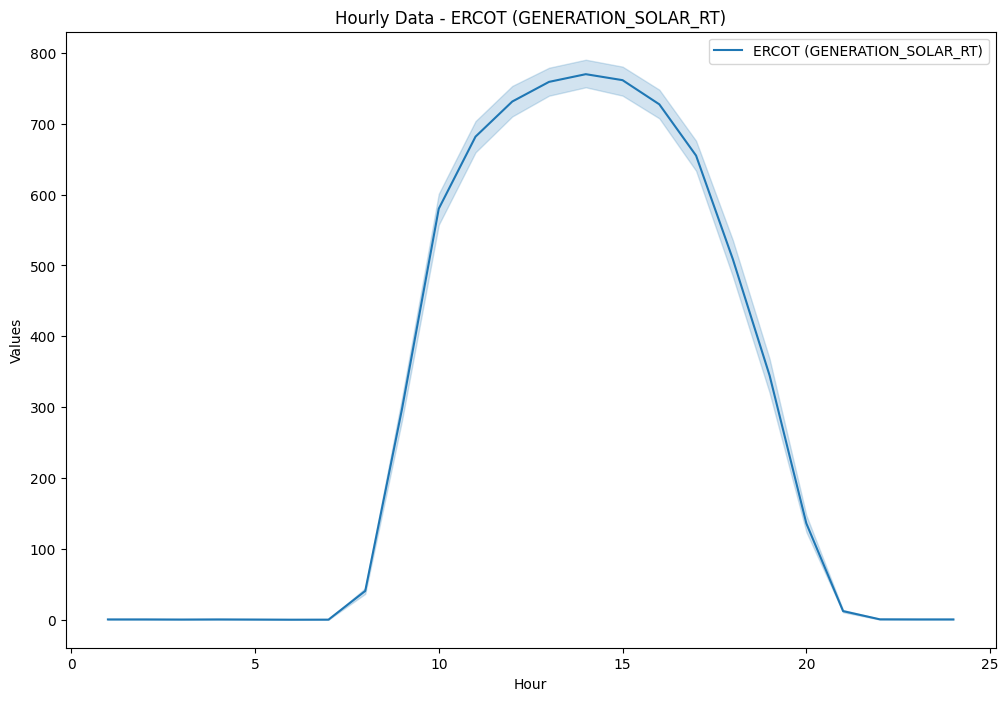

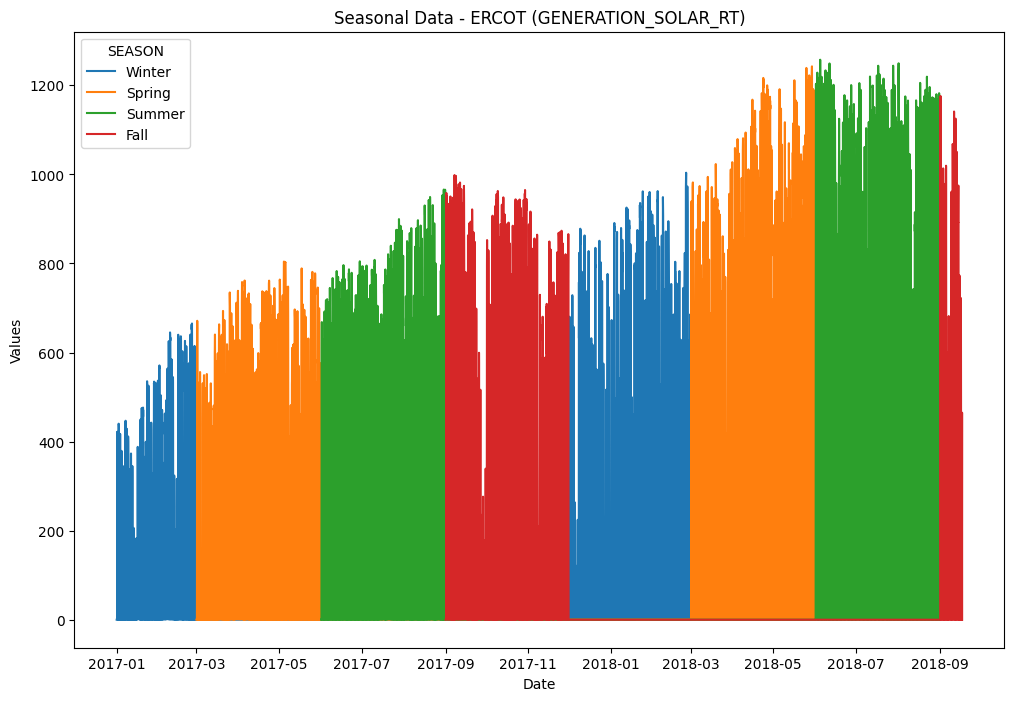

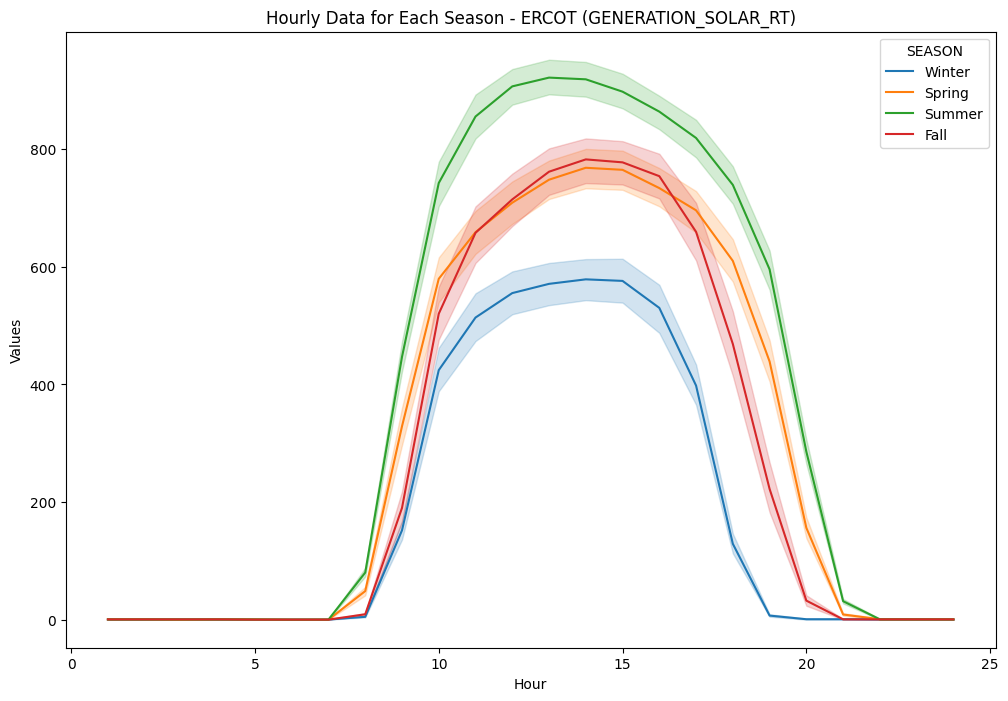

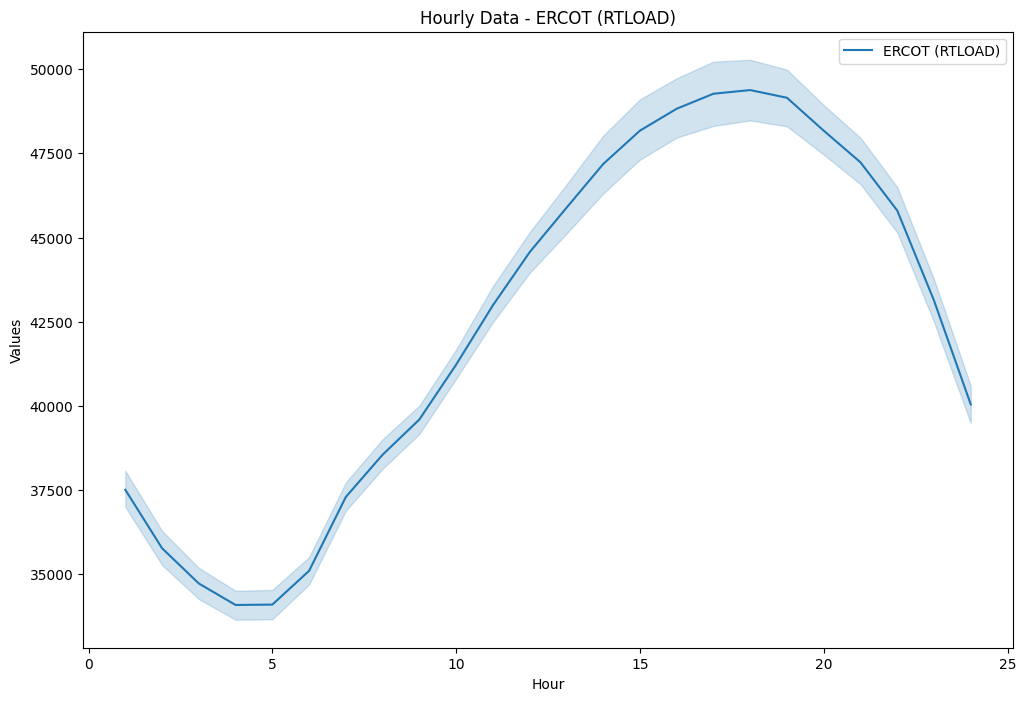

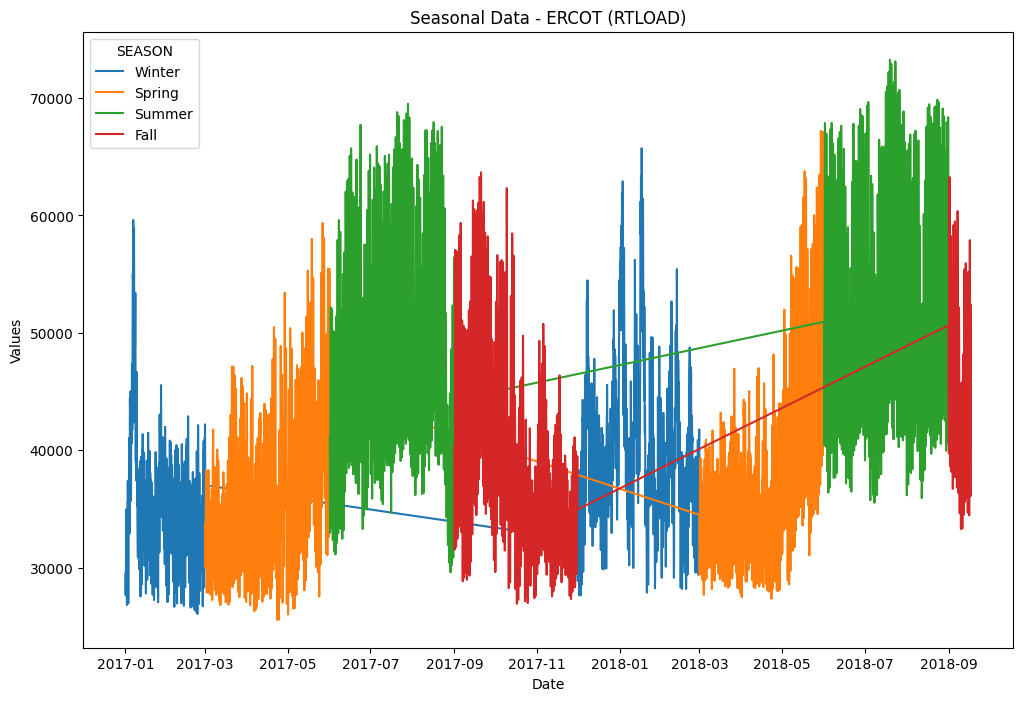

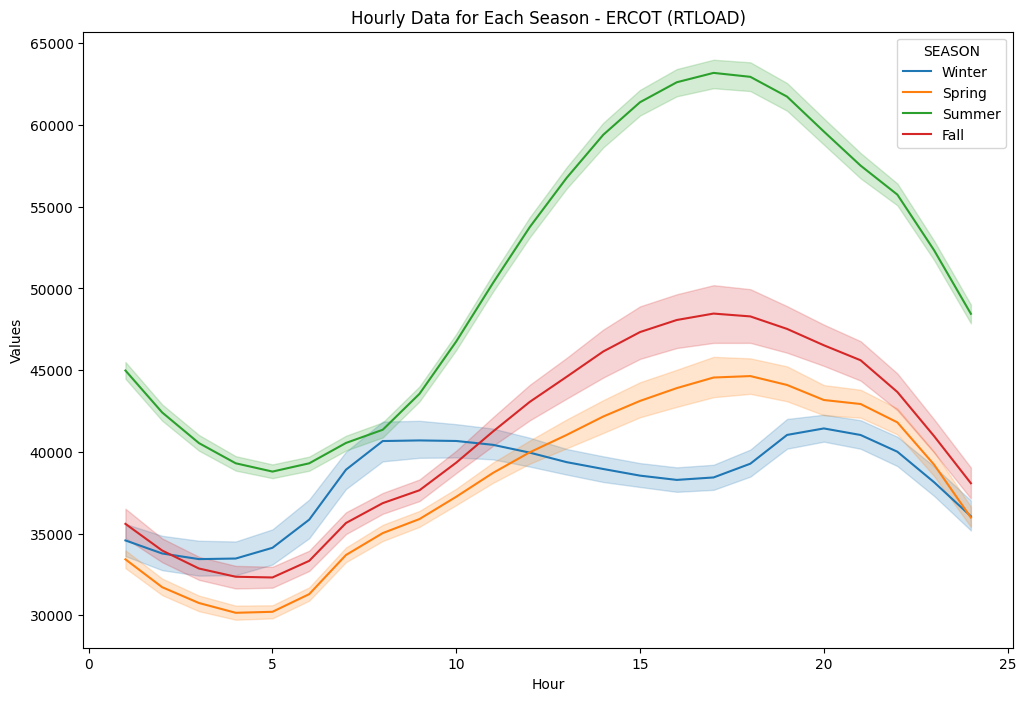

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure DATETIME is in datetime format
df_filled['DATETIME'] = pd.to_datetime(df_filled['DATETIME'])
# Extract hour, month, and season for further analysis
df_filled['MONTH'] = df_filled['DATETIME'].dt.month
df_filled['SEASON'] = df_filled['MONTH'] % 12 // 3 + 1
df_filled['SEASON'] = df_filled['SEASON'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# Plotting functions

def plot_hourly_data(df, column):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df, x='HOURENDING', y=column, label=column)
    plt.title(f'Hourly Data - {column}')
    plt.xlabel('Hour')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

def plot_seasonal_data_corrected(df, column):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df, x='DATETIME', y=column, hue='SEASON', legend='full')
    plt.title(f'Seasonal Data - {column}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend(title='SEASON')
    plt.show()

def plot_hourly_seasonal_data(df, column):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df[df['Variable'] == column], x='HOURENDING', y='Value', hue='SEASON')
    plt.title(f'Hourly Data for Each Season - {column}')
    plt.xlabel('Hour')
    plt.ylabel('Values')
    plt.legend(title='SEASON')
    plt.show()

# Generate plots for each variable
variables = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']

# Melt the dataframe
df_melted = df_filled.melt(id_vars=['DATETIME', 'HOURENDING', 'SEASON'],
                    value_vars=variables,
                    var_name='Variable', value_name='Value')

for var in variables:
    plot_hourly_data(df_filled, var)
    plot_seasonal_data_corrected(df_filled, var)
    plot_hourly_seasonal_data(df_melted, var)


Change catogory variable to one-hot code

In [ ]:
# Apply one-hot encoding to the 'SEASON' column
df_filled = pd.get_dummies(df_filled, columns=['SEASON'], prefix='SEASON')
df_filled = pd.get_dummies(df_filled, columns=['PEAKTYPE'], prefix='PEAKTYPE')
df_filled = pd.get_dummies(df_filled, columns=['MONTH'], prefix='MONTH')
df_filled = pd.get_dummies(df_filled, columns=['HOURENDING'], prefix='HOURENDING')

# Display the modified DataFrame
print(df_filled.head())

             DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
0 2017-01-01 01:00:00           23.3575           2155.31   
1 2017-01-01 02:00:00           21.4650           2313.81   
2 2017-01-01 03:00:00           20.7350           2587.68   
3 2017-01-01 04:00:00           20.2700           2748.65   
4 2017-01-01 05:00:00           20.1200           2757.49   

   ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  MARKETDAY  YEAR  SEASON_Fall  \
0                          0.0    29485.791355 2017-01-01  2017        False   
1                          0.0    28911.565913 2017-01-01  2017        False   
2                          0.0    28238.258175 2017-01-01  2017        False   
3                          0.0    27821.000513 2017-01-01  2017        False   
4                          0.0    27646.942413 2017-01-01  2017        False   

   SEASON_Spring  SEASON_Summer  ...  HOURENDING_15  HOURENDING_16  \
0          False          False  ...          False          False   
1          F

In [ ]:
# Checking for missing values
missing_values = df_filled.isnull().sum()
print(missing_values)

DATETIME                       0
HB_NORTH (RTLMP)               0
ERCOT (WIND_RTI)               0
ERCOT (GENERATION_SOLAR_RT)    0
ERCOT (RTLOAD)                 0
MARKETDAY                      0
YEAR                           0
SEASON_Fall                    0
SEASON_Spring                  0
SEASON_Summer                  0
SEASON_Winter                  0
PEAKTYPE_OFFPEAK               0
PEAKTYPE_WDPEAK                0
PEAKTYPE_WEPEAK                0
MONTH_1                        0
MONTH_2                        0
MONTH_3                        0
MONTH_4                        0
MONTH_5                        0
MONTH_6                        0
MONTH_7                        0
MONTH_8                        0
MONTH_9                        0
MONTH_10                       0
MONTH_11                       0
MONTH_12                       0
HOURENDING_1                   0
HOURENDING_2                   0
HOURENDING_3                   0
HOURENDING_4                   0
HOURENDING

In [ ]:
# Columns to check for outliers
columns_to_check = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']
# Check for negative values
print(df_filled[columns_to_check].min())

HB_NORTH (RTLMP)                   0.005000
ERCOT (WIND_RTI)                   0.000000
ERCOT (GENERATION_SOLAR_RT)        0.000000
ERCOT (RTLOAD)                 25566.511248
dtype: float64


In [ ]:
# Check for NaNs
print(df_filled[columns_to_check].isnull().sum())

HB_NORTH (RTLMP)               0
ERCOT (WIND_RTI)               0
ERCOT (GENERATION_SOLAR_RT)    0
ERCOT (RTLOAD)                 0
dtype: int64


Do log to the column to handle outliers problem

In [ ]:
import numpy as np
# Apply log transformation to the specified columns
df_filled[columns_to_check] = df_filled[columns_to_check].apply(lambda x: np.log(x + 1))

In [ ]:
# Checking for missing values
missing_values = df_filled.isnull().sum()
print(missing_values)

DATETIME                       0
HB_NORTH (RTLMP)               0
ERCOT (WIND_RTI)               0
ERCOT (GENERATION_SOLAR_RT)    0
ERCOT (RTLOAD)                 0
MARKETDAY                      0
YEAR                           0
SEASON_Fall                    0
SEASON_Spring                  0
SEASON_Summer                  0
SEASON_Winter                  0
PEAKTYPE_OFFPEAK               0
PEAKTYPE_WDPEAK                0
PEAKTYPE_WEPEAK                0
MONTH_1                        0
MONTH_2                        0
MONTH_3                        0
MONTH_4                        0
MONTH_5                        0
MONTH_6                        0
MONTH_7                        0
MONTH_8                        0
MONTH_9                        0
MONTH_10                       0
MONTH_11                       0
MONTH_12                       0
HOURENDING_1                   0
HOURENDING_2                   0
HOURENDING_3                   0
HOURENDING_4                   0
HOURENDING

In [ ]:
df_filled.describe()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),MARKETDAY,YEAR
count,14912,14912.000000,14912.000000,14912.000000,14912.000000,14912,14912.000000
mean,2017-11-09 21:23:00.659871488,3.122402,8.723232,3.190896,10.630322,2017-11-09 08:51:12.746780928,2017.416376
min,2017-01-01 01:00:00,0.004988,0.000000,0.000000,10.149078,2017-01-01 00:00:00,2017.000000
25%,2017-06-07 10:45:00,2.948477,8.324197,0.000000,10.476960,2017-06-07 00:00:00,2017.000000
50%,2017-11-10 01:30:00,3.048265,8.887825,3.224261,10.596208,2017-11-10 00:00:00,2017.000000
75%,2018-04-14 17:15:00,3.260929,9.287987,6.416965,10.778876,2018-04-14 00:00:00,2018.000000
max,2018-09-17 12:00:00,7.941067,9.920905,7.137708,11.201847,2018-09-17 00:00:00,2018.000000
std,NaN,0.459732,0.731657,3.010320,0.222300,NaN,0.492974


### Correlation analysis

In [ ]:
# Analyze correlation and covariance using the correct column name
columns_for_analysis = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)', 'SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Winter', 'PEAKTYPE_OFFPEAK', 'PEAKTYPE_WDPEAK', 'PEAKTYPE_WEPEAK']

correlation_matrix = df_filled[columns_for_analysis].corr()
covariance_matrix = df_filled[columns_for_analysis].cov()
print(correlation_matrix)
print(covariance_matrix)

                             HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
HB_NORTH (RTLMP)                     1.000000         -0.364943   
ERCOT (WIND_RTI)                    -0.364943          1.000000   
ERCOT (GENERATION_SOLAR_RT)          0.355977         -0.234557   
ERCOT (RTLOAD)                       0.591535         -0.135480   
SEASON_Fall                         -0.046922         -0.100627   
SEASON_Spring                       -0.106962          0.196180   
SEASON_Summer                        0.217695         -0.140350   
SEASON_Winter                       -0.077355          0.030017   
PEAKTYPE_OFFPEAK                    -0.368312          0.191597   
PEAKTYPE_WDPEAK                      0.269517         -0.111568   
PEAKTYPE_WEPEAK                      0.096679         -0.085840   

                             ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  \
HB_NORTH (RTLMP)                                0.355977        0.591535   
ERCOT (WIND_RTI)                           

Negative Impact of Wind Generation: Higher wind generation tends to lower electricity prices, possibly due to the increased supply of electricity from wind.

Positive Impact of Solar Generation: Higher solar generation is associated with higher electricity prices, which might be influenced by factors such as time of day and demand patterns.

Seasonal Variations: Significant seasonal effects on electricity prices and real-time load are observed, with summer showing higher demand and prices.

Peak Type Influences: Prices are lower during off-peak hours and higher during weekday peak hours, reflecting typical demand patterns.

##Linear regression model

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Load the data from the provided Excel file
file_path = '/content/Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(file_path)

# Checking for missing values
missing_values = df.isnull().sum()

# Replace missing values with 0
df_filled = df.fillna(0)

missing_values_after = df_filled.isnull().sum()

datetime_column = 'DATETIME'

# Select only numerical columns, excluding the datetime column
numerical_columns = df_filled.select_dtypes(include=['number']).columns

# Calculate the number of negative values in the numerical columns
negative_value_count = (df_filled[numerical_columns] < 0).sum().sum()
print(f"Number of negative values: {negative_value_count}")

# Delete rows containing negative values in the numerical columns
df_filled = df_filled[(df_filled[numerical_columns] >= 0).all(axis=1)]

# Optionally, reset the index if you want a clean DataFrame after deletion
df_filled.reset_index(drop=True, inplace=True)

def replace_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.5)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 -  IQR
    upper_bound = Q3 + IQR

    # Identify outliers and replace them with lower or upper bound
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)

    # Fill NaNs with the nearest normal value
    df[column] = df[column].fillna(0)

    return df

# Columns to check for outliers
columns_to_check = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']

import numpy as np
# Apply log transformation to the specified columns
df_filled[columns_to_check] = df_filled[columns_to_check].apply(lambda x: np.log(x + 1))

# Replace outliers for each column
for column in columns_to_check:
    df_filled = replace_outliers_iqr(df_filled, column)


# Ensure DATETIME is in datetime format
df_filled['DATETIME'] = pd.to_datetime(df_filled['DATETIME'])
# Extract hour, month, and season for further analysis
df_filled['MONTH'] = df_filled['DATETIME'].dt.month
df_filled['SEASON'] = df_filled['MONTH'] % 12 // 3 + 1
df_filled['SEASON'] = df_filled['SEASON'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# Apply one-hot encoding to the 'SEASON' column
df_filled = pd.get_dummies(df_filled, columns=['SEASON'], prefix='SEASON')
df_filled = pd.get_dummies(df_filled, columns=['PEAKTYPE'], prefix='PEAKTYPE')
df_filled = pd.get_dummies(df_filled, columns=['MONTH'], prefix='MONTH')
df_filled = pd.get_dummies(df_filled, columns=['HOURENDING'], prefix='HOURENDING')

# Define the features (X) and target (y)
X = df_filled.drop(['DATETIME', 'HB_NORTH (RTLMP)', 'MARKETDAY','YEAR'], axis=1)
y = df_filled['HB_NORTH (RTLMP)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model as a baseline
lr_model = LinearRegression()

# Train the Linear Regression model
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)
# Calculate metrics
def metrics(y_test,y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    data = {
        'Metric': [ 'MAPE', 'R2', 'MAE', 'MSE'],
        'Value': [ mape, r2, mae, mse]
    }
    df = pd.DataFrame(data)
    print(df)

# Evaluate the Linear Regression model
# Calculate metrics
metrics(y_test,y_pred_lr)

Number of negative values: 75
  Metric     Value
0   MAPE  4.449482
1     R2  0.614294
2    MAE  0.142425
3    MSE  0.046270


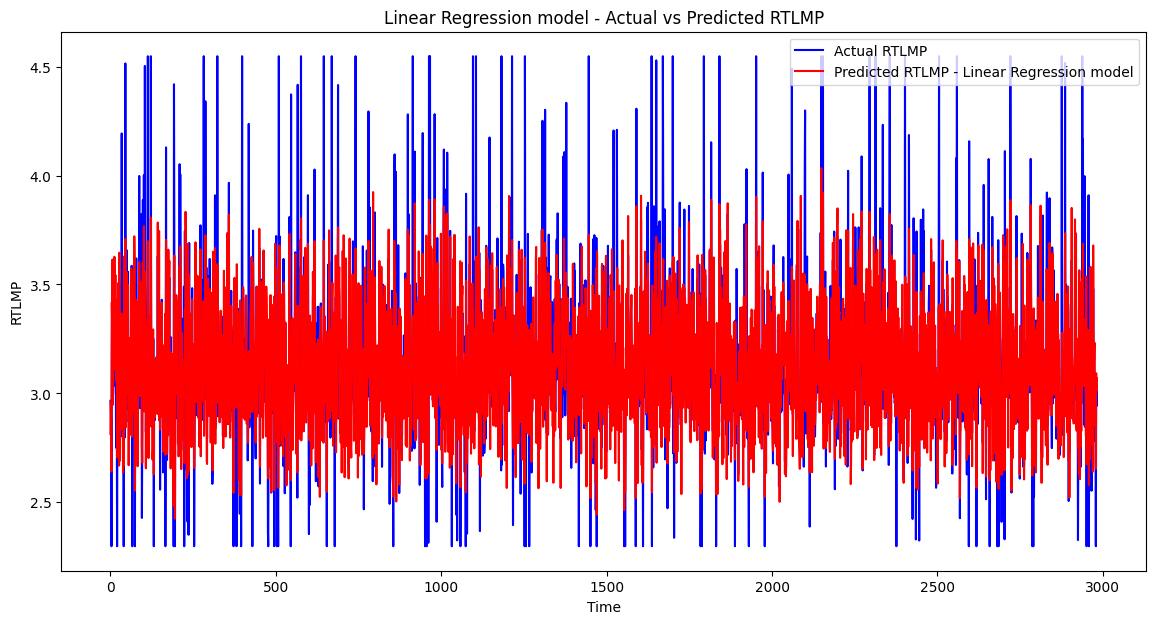

In [ ]:
# Visualization of the Random Forest model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual RTLMP', color='blue')
plt.plot(y_pred_lr, label='Predicted RTLMP - Linear Regression model', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('Linear Regression model - Actual vs Predicted RTLMP')
plt.legend()
plt.show()

## Random Forest

Tree model is robust to outliers, I try to use tree model.

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


  Metric     Value
0   MAPE  3.650011
1     R2  0.677106
2    MAE  0.118323
3    MSE  0.038735


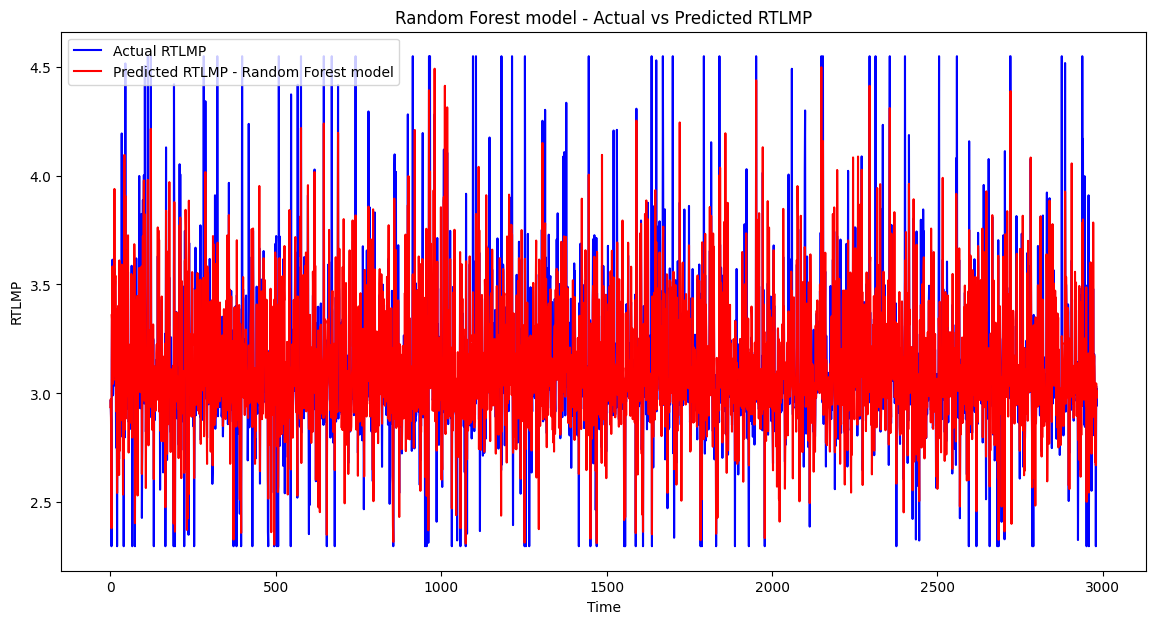

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error

# Split the data (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Train the model
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Predict on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Calculate metrics
def metrics(y_test, y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    data = {
        'Metric': ['MAPE', 'R2', 'MAE', 'MSE'],
        'Value': [mape, r2, mae, mse]
    }
    df = pd.DataFrame(data)
    print(df)

# Evaluate the Random Forest model
metrics(y_test, y_pred_rf)

# Visualization of the Random Forest model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual RTLMP', color='blue')
plt.plot(y_pred_rf, label='Predicted RTLMP - Random Forest model', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('Random Forest model - Actual vs Predicted RTLMP')
plt.legend()
plt.show()


I aim to develop three separate RandomForestRegressor models to predict 'HB_NORTH (RTLMP)' values. The first model will be trained for the hours between 6 and 8, the second for the hours between 16 and 18, and the third for the remaining hours of the day. After training these models, I will combine their predictions to evaluate the overall performance using appropriate metrics.

The rationale behind this approach is that electricity market prices often exhibit distinct patterns and behaviors during different times of the day. By segmenting the data into these specific hour ranges, I can capture the unique characteristics and dynamics of each period more effectively. This segmentation allows each model to focus on a narrower set of patterns, potentially improving the accuracy and reliability of the predictions compared to a single model trained on the entire dataset. Combining the predictions from these specialized models provides a comprehensive view of the model performance across different times of the day, leading to a more robust evaluation.

Number of negative values: 75
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  Metric     Value
0   MAPE  4.483313
1     R2  0.616486
2    MAE  0.140261
3    MSE  0.061750


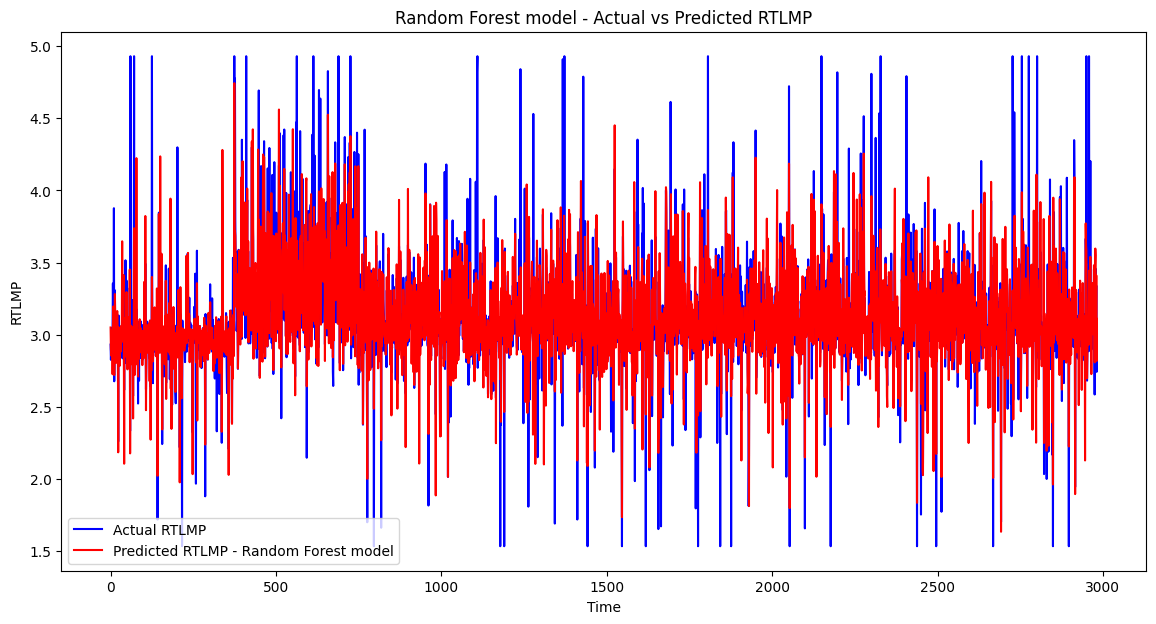

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns

# Load the data from the provided Excel file
file_path = '/content/Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(file_path)

# Checking for missing values
missing_values = df.isnull().sum()

# Replace missing values with 0
df_filled = df.fillna(0)

datetime_column = 'DATETIME'

# Select only numerical columns, excluding the datetime column
numerical_columns = df_filled.select_dtypes(include=['number']).columns

# Calculate the number of negative values in the numerical columns
negative_value_count = (df_filled[numerical_columns] < 0).sum().sum()
print(f"Number of negative values: {negative_value_count}")

# Delete rows containing negative values in the numerical columns
df_filled = df_filled[(df_filled[numerical_columns] >= 0).all(axis=1)]

# Optionally, reset the index if you want a clean DataFrame after deletion
df_filled.reset_index(drop=True, inplace=True)

def replace_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR
    upper_bound = Q3 + IQR

    # Identify outliers and replace them with lower or upper bound
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)

    return df

# Columns to check for outliers
columns_to_check = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']

import numpy as np
# Apply log transformation to the specified columns
df_filled[columns_to_check] = df_filled[columns_to_check].apply(lambda x: np.log(x + 1))

# Replace outliers for each column
for column in columns_to_check:
    df_filled = replace_outliers_iqr(df_filled, column)

# Ensure DATETIME is in datetime format
df_filled['DATETIME'] = pd.to_datetime(df_filled['DATETIME'])
# Extract hour, month, and season for further analysis
df_filled['HOUR'] = df_filled['DATETIME'].dt.hour
df_filled['MONTH'] = df_filled['DATETIME'].dt.month
df_filled['SEASON'] = df_filled['MONTH'] % 12 // 3 + 1
df_filled['SEASON'] = df_filled['SEASON'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# Apply one-hot encoding to the 'SEASON' and 'PEAKTYPE' columns
df_filled = pd.get_dummies(df_filled, columns=['SEASON', 'PEAKTYPE', 'MONTH', 'HOURENDING'], prefix=['SEASON', 'PEAKTYPE', 'MONTH', 'HOURENDING'])

# Define a function to build and evaluate the model for a specific hour range
def build_and_evaluate_model(df, hour_range):
    df_hour_range = df[df['HOUR'].isin(hour_range)]

    # Define the features (X) and target (y)
    X = df_hour_range.drop(['DATETIME', 'HB_NORTH (RTLMP)', 'MARKETDAY', 'YEAR', 'HOUR'], axis=1)
    y = df_hour_range['HB_NORTH (RTLMP)']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
    }

    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(random_state=42)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')

    # Train the model
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_rf_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred_rf = best_rf_model.predict(X_test)

    return y_test, y_pred_rf

# Build and evaluate models for different hour ranges
y_test_6_8, y_pred_6_8 = build_and_evaluate_model(df_filled, range(6, 9))
y_test_16_18, y_pred_16_18 = build_and_evaluate_model(df_filled, range(16, 19))
y_test_rest, y_pred_rest = build_and_evaluate_model(df_filled, [h for h in range(24) if h not in range(6, 9) and h not in range(16, 19)])

# Combine the predictions
y_test_combined = pd.concat([y_test_6_8, y_test_16_18, y_test_rest])
y_pred_combined = np.concatenate([y_pred_6_8, y_pred_16_18, y_pred_rest])

# Calculate metrics
def metrics(y_test, y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    data = {
        'Metric': ['MAPE', 'R2', 'MAE', 'MSE'],
        'Value': [mape, r2, mae, mse]
    }
    df = pd.DataFrame(data)
    print(df)

# Evaluate the combined model
metrics(y_test_combined, y_pred_combined)

# Visualization of the combined model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_combined.values, label='Actual RTLMP', color='blue')
plt.plot(y_pred_combined, label='Predicted RTLMP - Random Forest model', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('Random Forest model - Actual vs Predicted RTLMP')
plt.legend()
plt.show()


## XGBoost

Fitting 3 folds for each of 162 candidates, totalling 486 fits
  Metric      Value
0   MAPE  21.583922
1     R2   0.620058
2    MAE   0.138033
3    MSE   0.071735


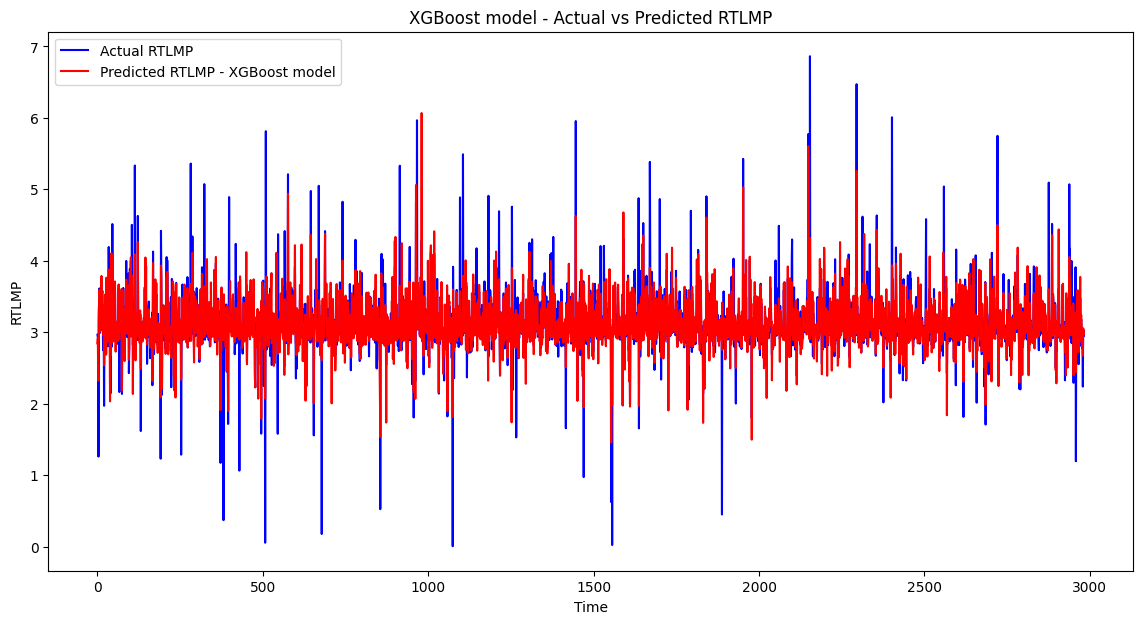

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

# Split the data (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Train the model
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Predict on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate metrics
def metrics(y_test, y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    data = {
        'Metric': ['MAPE', 'R2', 'MAE', 'MSE'],
        'Value': [mape, r2, mae, mse]
    }
    df = pd.DataFrame(data)
    print(df)

# Evaluate the XGBoost model
metrics(y_test, y_pred_xgb)

# Visualization of the XGBoost model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual RTLMP', color='blue')
plt.plot(y_pred_xgb, label='Predicted RTLMP - XGBoost model', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('XGBoost model - Actual vs Predicted RTLMP')
plt.legend()
plt.show()


## Gradient Boosting Regressor

Fitting 3 folds for each of 27 candidates, totalling 81 fits
  Metric      Value
0   MAPE  22.345098
1     R2   0.593429
2    MAE   0.142008
3    MSE   0.076763


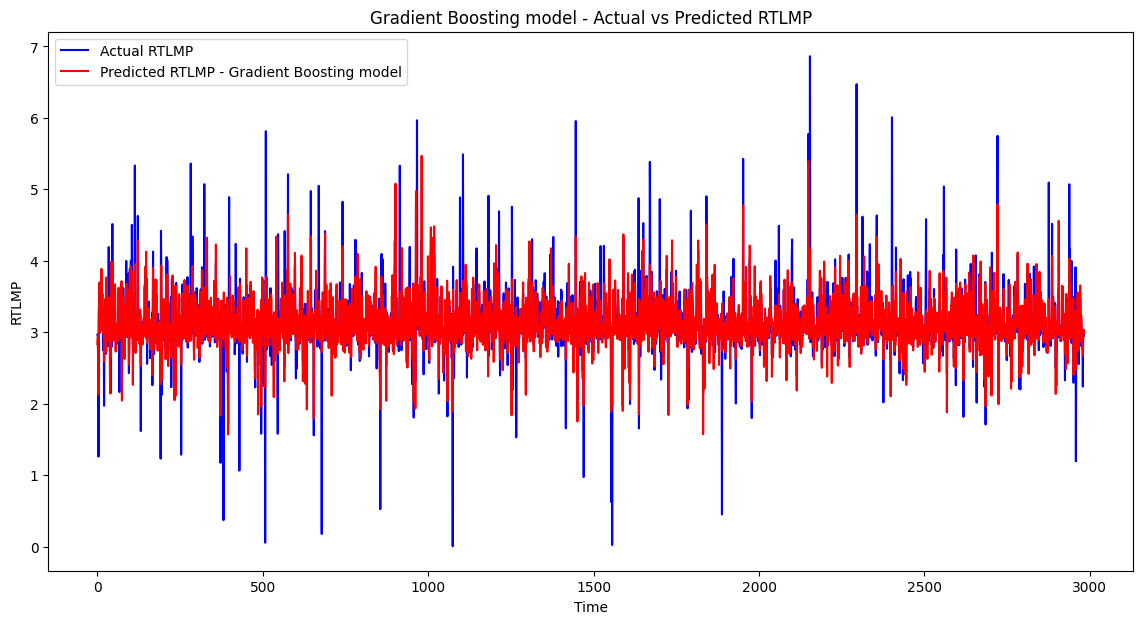

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# Split the data (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Initialize the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Train the model
grid_search.fit(X_train, y_train)

# Get the best model
best_gbr_model = grid_search.best_estimator_

# Predict on the test set
y_pred_gbr = best_gbr_model.predict(X_test)

# Calculate metrics
def metrics(y_test, y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    data = {
        'Metric': ['MAPE', 'R2', 'MAE', 'MSE'],
        'Value': [mape, r2, mae, mse]
    }
    df = pd.DataFrame(data)
    print(df)

# Evaluate the Gradient Boosting model
metrics(y_test, y_pred_gbr)

# Visualization of the Gradient Boosting model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual RTLMP', color='blue')
plt.plot(y_pred_gbr, label='Predicted RTLMP - Gradient Boosting model', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('Gradient Boosting model - Actual vs Predicted RTLMP')
plt.legend()
plt.show()

##LSTM

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


Index(['DATETIME', 'HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)',
       'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)', 'HOURENDING',
       'MARKETDAY', 'PEAKTYPE', 'MONTH', 'YEAR'],
      dtype='object')
Training model with units=50, dropout_rate=0.2, learning_rate=0.001, batch_size=32, epochs=100


<ipython-input-1-1226e6a0e020>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filled['DATETIME'] = pd.to_datetime(df_filled['DATETIME'])
<ipython-input-1-1226e6a0e020>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filled['HOUR'] = df_filled['DATETIME'].dt.hour
<ipython-input-1-1226e6a0e020>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

94/94 [==============================] - 1s 2ms/step
Training model with units=50, dropout_rate=0.2, learning_rate=0.0005, batch_size=32, epochs=100
94/94 [==============================] - 1s 2ms/step
Training model with units=50, dropout_rate=0.2, learning_rate=0.0001, batch_size=32, epochs=100
94/94 [==============================] - 1s 2ms/step
Training model with units=50, dropout_rate=0.3, learning_rate=0.001, batch_size=32, epochs=100
94/94 [==============================] - 1s 2ms/step
Training model with units=50, dropout_rate=0.3, learning_rate=0.0005, batch_size=32, epochs=100
94/94 [==============================] - 1s 2ms/step
Training model with units=50, dropout_rate=0.3, learning_rate=0.0001, batch_size=32, epochs=100
94/94 [==============================] - 1s 2ms/step
Training model with units=50, dropout_rate=0.4, learning_rate=0.001, batch_size=32, epochs=100
94/94 [==============================] - 1s 2ms/step
Training model with units=50, dropout_rate=0.4, learnin

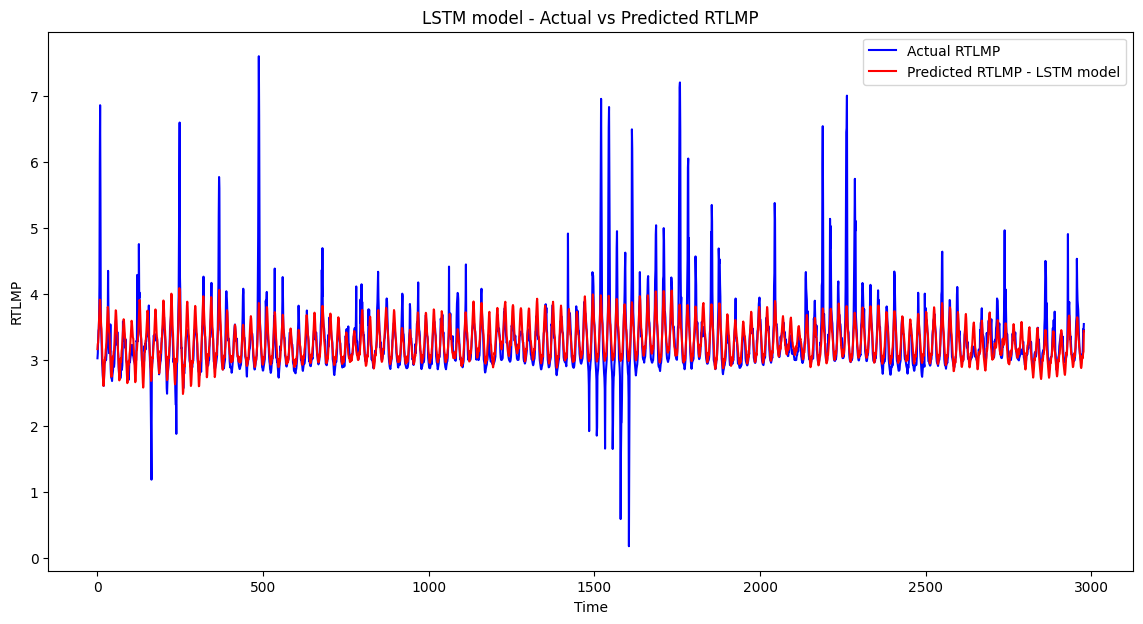

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the data from the provided Excel file
file_path = '/content/Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(file_path)

# Print the column names to verify
print(df.columns)

# Checking for missing values and replace with 0
df.fillna(0, inplace=True)

# Handle negative values
numerical_columns = df.select_dtypes(include=['number']).columns
df_filled = df[(df[numerical_columns] >= 0).all(axis=1)]

# Define the target variable
target = 'HB_NORTH (RTLMP)'

# Feature engineering
df_filled['DATETIME'] = pd.to_datetime(df_filled['DATETIME'])
df_filled['HOUR'] = df_filled['DATETIME'].dt.hour
df_filled['MONTH'] = df_filled['DATETIME'].dt.month
df_filled['SEASON'] = df_filled['MONTH'] % 12 // 3 + 1
df_filled['SEASON'] = df_filled['SEASON'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# One-hot encoding
df_filled = pd.get_dummies(df_filled, columns=['SEASON'], prefix='SEASON')
df_filled = pd.get_dummies(df_filled, columns=['PEAKTYPE'], prefix='PEAKTYPE')
df_filled = pd.get_dummies(df_filled, columns=['MONTH'], prefix='MONTH')
df_filled = pd.get_dummies(df_filled, columns=['HOURENDING'], prefix='HOURENDING')
columns_to_check = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']

# Apply log transformation
df_filled[columns_to_check] = df_filled[columns_to_check].apply(lambda x: np.log(x + 1))

# Ensure no missing values after transformation
df = df_filled.dropna()


# Select features (excluding 'DATETIME', 'HB_NORTH (RTLMP)', 'MARKETDAY', 'YEAR')
features = df.columns.difference(['DATETIME', 'HB_NORTH (RTLMP)', 'MARKETDAY', 'YEAR'])

# Normalize the data
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df[target] = scaler.fit_transform(df[[target]])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24  # Using past 24 hours to predict the next hour
data = df[features.tolist() + [target]].values
X, y = create_sequences(data, seq_length)

# Split into training and test sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Function to create the LSTM model
def create_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(seq_length, len(features))),
        Dropout(dropout_rate),
        LSTM(units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Hyperparameter grid
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [32],
    'epochs': [100]
}

# Manual hyperparameter tuning
best_score = float('inf')
best_params = None
best_model = None

for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    print(f'Training model with units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}')
                    model = create_model(units, dropout_rate, learning_rate)
                    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)
                    y_pred = model.predict(X_test)
                    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]
                    y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
                    mse = mean_squared_error(y_test_inv, y_pred_inv)
                    if mse < best_score:
                        best_score = mse
                        best_params = {
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }
                        best_model = model

print(f'Best hyperparameters: {best_params}')
print(f'Best MSE: {best_score}')

# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Calculate metrics
def calculate_metrics(y_test, y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    data = {
        'Metric': ['MAPE', 'R2', 'MAE', 'MSE'],
        'Value': [mape, r2, mae, mse]
    }
    df_metrics = pd.DataFrame(data)
    print(df_metrics)
    return df_metrics

metrics_df = calculate_metrics(y_test_inv, y_pred_inv)

# Visualization of the LSTM model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual RTLMP', color='blue')
plt.plot(y_pred_inv, label='Predicted RTLMP - LSTM model', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('LSTM model - Actual vs Predicted RTLMP')
plt.legend()
plt.show()


## LPCA model

LASSO principal component averaging (LPCA) Combines PCA and LASSO, where PCA extracts principal components from a large panel of forecasts, and LASSO is used to select the most relevant components by shrinking less important parameters to zero.

Number of negative values: 75


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-packa

  Metric     Value
0   MAPE  5.340049
1     R2  0.545259
2    MAE  0.162489
3    MSE  0.068518


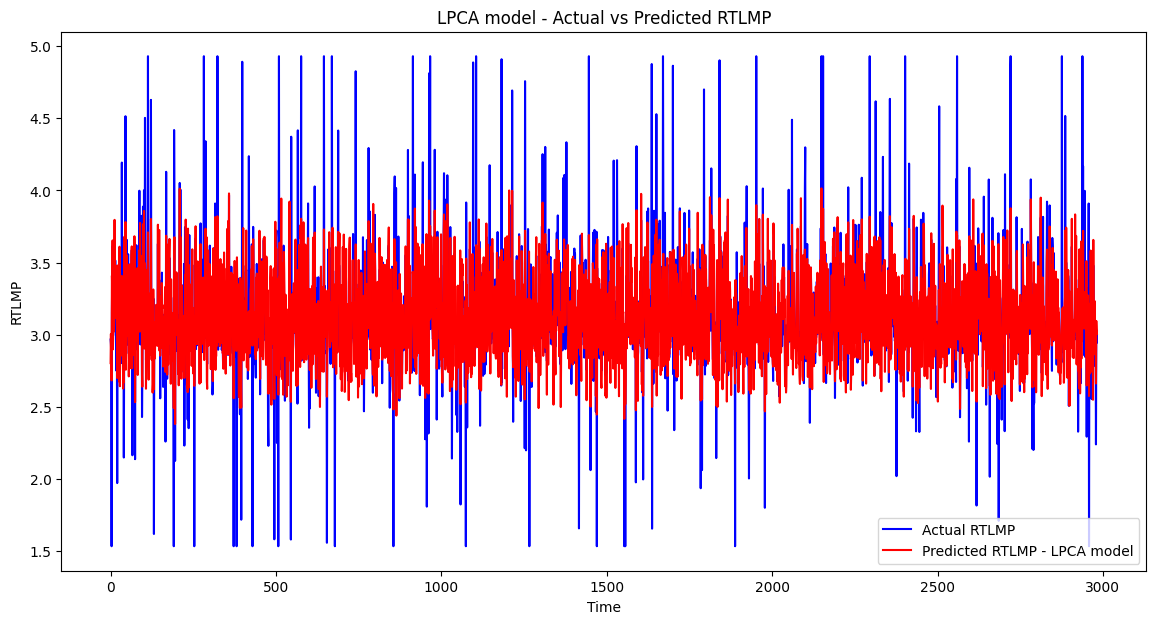

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# Load the data from the provided Excel file
file_path = '/content/Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(file_path)

# Checking for missing values
missing_values = df.isnull().sum()

# Replace missing values with 0
df_filled = df.fillna(0)

missing_values_after = df_filled.isnull().sum()

datetime_column = 'DATETIME'

# Select only numerical columns, excluding the datetime column
numerical_columns = df_filled.select_dtypes(include=['number']).columns

# Calculate the number of negative values in the numerical columns
negative_value_count = (df_filled[numerical_columns] < 0).sum().sum()
print(f"Number of negative values: {negative_value_count}")

# Delete rows containing negative values in the numerical columns
df_filled = df_filled[(df_filled[numerical_columns] >= 0).all(axis=1)]

# Optionally, reset the index if you want a clean DataFrame after deletion
df_filled.reset_index(drop=True, inplace=True)

def replace_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR
    upper_bound = Q3 + IQR

    # Identify outliers and replace them with lower or upper bound
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)

    # Fill NaNs with the nearest normal value
    df[column] = df[column].fillna(0)

    return df

# Columns to check for outliers
columns_to_check = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']

import numpy as np
# Apply log transformation to the specified columns
df_filled[columns_to_check] = df_filled[columns_to_check].apply(lambda x: np.log(x + 1))

# Replace outliers for each column
for column in columns_to_check:
    df_filled = replace_outliers_iqr(df_filled, column)


# Ensure DATETIME is in datetime format
df_filled['DATETIME'] = pd.to_datetime(df_filled['DATETIME'])
# Extract hour, month, and season for further analysis
df_filled['MONTH'] = df_filled['DATETIME'].dt.month
df_filled['SEASON'] = df_filled['MONTH'] % 12 // 3 + 1
df_filled['SEASON'] = df_filled['SEASON'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# Apply one-hot encoding to the 'SEASON' column
df_filled = pd.get_dummies(df_filled, columns=['SEASON'], prefix='SEASON')
df_filled = pd.get_dummies(df_filled, columns=['PEAKTYPE'], prefix='PEAKTYPE')
df_filled = pd.get_dummies(df_filled, columns=['MONTH'], prefix='MONTH')
df_filled = pd.get_dummies(df_filled, columns=['HOURENDING'], prefix='HOURENDING')

# Define the features (X) and target (y)
X = df_filled.drop(['DATETIME', 'HB_NORTH (RTLMP)', 'MARKETDAY','YEAR'], axis=1)
y = df_filled['HB_NORTH (RTLMP)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline with PCA and Lasso
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lasso', LassoCV(cv=5))
])

# Define the parameter grid
param_grid = {
    'pca__n_components': [10, 20, 30, 40, 50]  # Test different numbers of components
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict and evaluate the model
y_pred_best = best_model.predict(X_test)

# Calculate metrics
def metrics(y_test, y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    data = {
        'Metric': ['MAPE', 'R2', 'MAE', 'MSE'],
        'Value': [mape, r2, mae, mse]
    }
    df = pd.DataFrame(data)
    print(df)

metrics(y_test,y_pred_best)

# Visualization of the Random Forest model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual RTLMP', color='blue')
plt.plot(y_pred_best, label='Predicted RTLMP - LPCA model', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('LPCA model - Actual vs Predicted RTLMP')
plt.legend()
plt.show()


## Enhanced LPCA model

Enhance the model by adding more lagged prices, nonlinear effects, and exogenous variables in the model

Number of negative values: 75


<ipython-input-23-6a6864c7e630>:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filled[f'{col}_lag{lag}'] = df_filled[col].shift(lag)
<ipython-input-23-6a6864c7e630>:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filled[f'{col}_lag{lag}'] = df_filled[col].shift(lag)
<ipython-input-23-6a6864c7e630>:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

  Metric     Value
0   MAPE  3.599255
1     R2  0.773535
2    MAE  0.122086
3    MSE  0.041203


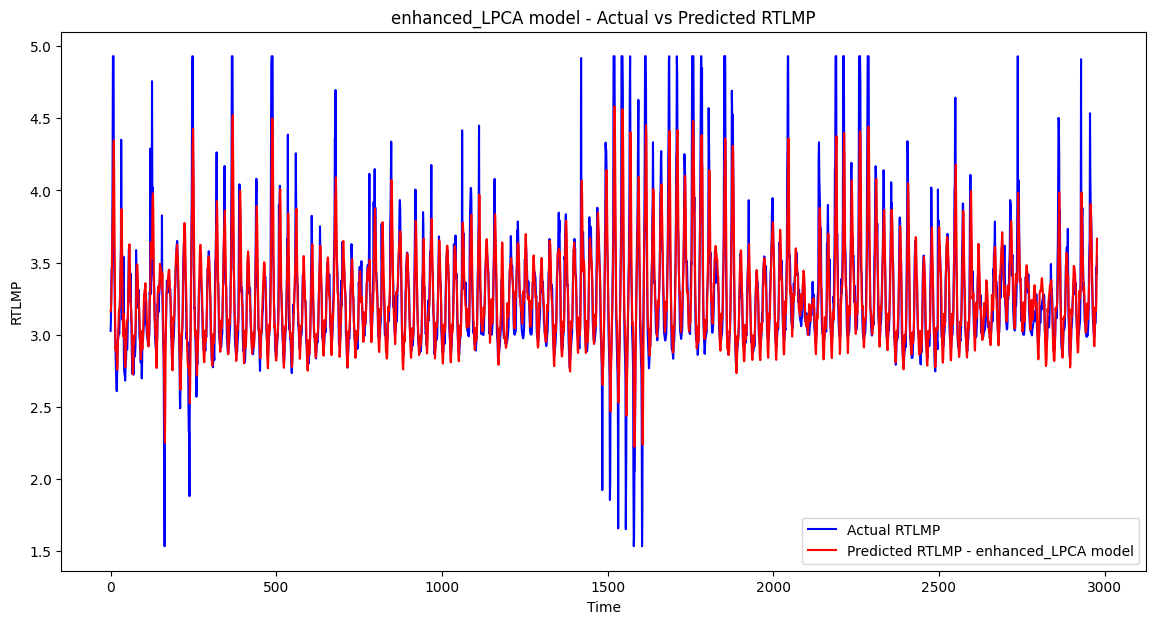

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Load the data from the provided Excel file
file_path = '/content/Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(file_path)

# Checking for missing values
missing_values = df.isnull().sum()

# Replace missing values with 0
df_filled = df.fillna(0)

# Select only numerical columns, excluding the datetime column
numerical_columns = df_filled.select_dtypes(include=['number']).columns

# Calculate the number of negative values in the numerical columns
negative_value_count = (df_filled[numerical_columns] < 0).sum().sum()
print(f"Number of negative values: {negative_value_count}")

# Delete rows containing negative values in the numerical columns
df_filled = df_filled[(df_filled[numerical_columns] >= 0).all(axis=1)]

# Optionally, reset the index if you want a clean DataFrame after deletion
df_filled.reset_index(drop=True, inplace=True)

# Define the columns to check for outliers
columns_to_check = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']

def replace_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR
    upper_bound = Q3 + IQR

    # Identify outliers and replace them with lower or upper bound
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)

    # Fill NaNs with the nearest normal value
    df[column] = df[column].fillna(0)

    return df

# Ensure DATETIME is in datetime format
df_filled['DATETIME'] = pd.to_datetime(df_filled['DATETIME'])
# Extract hour, month, and season for further analysis
df_filled['MONTH'] = df_filled['DATETIME'].dt.month
df_filled['SEASON'] = df_filled['MONTH'] % 12 // 3 + 1
df_filled['SEASON'] = df_filled['SEASON'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# Apply one-hot encoding to the 'SEASON' column
df_filled = pd.get_dummies(df_filled, columns=['SEASON'], prefix='SEASON')
df_filled = pd.get_dummies(df_filled, columns=['PEAKTYPE'], prefix='PEAKTYPE')
df_filled = pd.get_dummies(df_filled, columns=['MONTH'], prefix='MONTH')
df_filled = pd.get_dummies(df_filled, columns=['HOURENDING'], prefix='HOURENDING')

# Apply log transformation to the specified columns
df_filled[columns_to_check] = df_filled[columns_to_check].apply(lambda x: np.log(x + 1))

# Replace outliers for each column
for column in columns_to_check:
    df_filled = replace_outliers_iqr(df_filled, column)

# Feature Engineering: Adding lagged variables and nonlinear effects
lags = 24  # Number of lags

for col in columns_to_check:
    for lag in range(1, lags + 1):
        df_filled[f'{col}_lag{lag}'] = df_filled[col].shift(lag)

# Adding nonlinear effects: previous day's minimum and maximum prices
df_filled['HB_NORTH_min'] = df_filled['HB_NORTH (RTLMP)'].rolling(window=24).min().shift(1)
df_filled['HB_NORTH_max'] = df_filled['HB_NORTH (RTLMP)'].rolling(window=24).max().shift(1)

# Drop rows with NaN values generated by shifting
df_filled = df_filled.dropna()

# Prepare the features and target variable
X = df_filled.drop(columns=['DATETIME', 'HB_NORTH (RTLMP)', 'MARKETDAY'])
y = df_filled['HB_NORTH (RTLMP)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the pipeline with PCA and Lasso
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lasso', LassoCV(cv=5))
])

# Define the parameter grid
param_grid = {
    'pca__n_components': [10, 20, 30, 40, 50]  # Test different numbers of components
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict and evaluate the model
y_pred_best = best_model.predict(X_test)

metrics(y_test,y_pred_best)

# Visualization of the Random Forest model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual RTLMP', color='blue')
plt.plot(y_pred_best, label='Predicted RTLMP - enhanced_LPCA model', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('enhanced_LPCA model - Actual vs Predicted RTLMP')
plt.legend()
plt.show()


I aim to develop three separate LPCA models to predict 'HB_NORTH (RTLMP)' values. The first model will be trained for the hours between 6 and 8, the second for the hours between 16 and 18, and the third for the remaining hours of the day. After training these models, I will combine their predictions to evaluate the overall performance using appropriate metrics.

Number of negative values: 75


<ipython-input-25-4bca47ceba6f>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filled[f'{col}_lag{lag}'] = df_filled[col].shift(lag)
<ipython-input-25-4bca47ceba6f>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filled[f'{col}_lag{lag}'] = df_filled[col].shift(lag)
<ipython-input-25-4bca47ceba6f>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

Morning (6-8) - Metrics: {'MAE': 0.0612062937502236, 'MSE': 0.008772742486348014, 'R2': 0.6440641178445847, 'MAPE': 0.02179243091662488}
Afternoon (16-18) - Metrics: {'MAE': 0.1874598313863321, 'MSE': 0.0639234982431498, 'R2': 0.7431966917317346, 'MAPE': 0.04738329489293286}
Other Hours - Metrics: {'MAE': 0.09768575341117505, 'MSE': 0.03119139724367933, 'R2': 0.7587187038760203, 'MAPE': 0.029529354019661398}
Overall Metrics: {'MAE': 0.10438889765728912, 'MSE': 0.03249372941867677, 'R2': 0.8214673576129545, 'MAPE': 0.03080209707745627}


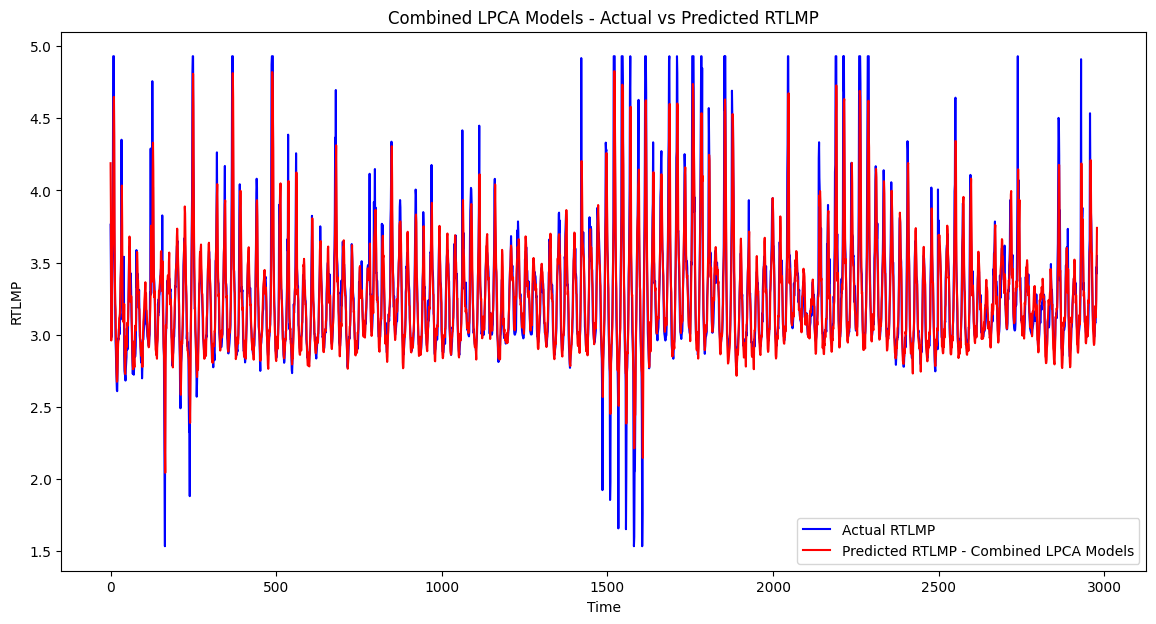

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# Load the data from the provided Excel file
file_path = '/content/Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(file_path)

# Checking for missing values
missing_values = df.isnull().sum()

# Replace missing values with 0
df_filled = df.fillna(0)

# Select only numerical columns, excluding the datetime column
numerical_columns = df_filled.select_dtypes(include=['number']).columns

# Calculate the number of negative values in the numerical columns
negative_value_count = (df_filled[numerical_columns] < 0).sum().sum()
print(f"Number of negative values: {negative_value_count}")

# Delete rows containing negative values in the numerical columns
df_filled = df_filled[(df_filled[numerical_columns] >= 0).all(axis=1)]

# Optionally, reset the index if you want a clean DataFrame after deletion
df_filled.reset_index(drop=True, inplace=True)

# Define the columns to check for outliers
columns_to_check = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']

def replace_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR
    upper_bound = Q3 + IQR

    # Identify outliers and replace them with lower or upper bound
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)

    # Fill NaNs with the nearest normal value
    df[column] = df[column].fillna(0)

    return df

# Ensure DATETIME is in datetime format
df_filled['DATETIME'] = pd.to_datetime(df_filled['DATETIME'])
# Extract hour, month, and season for further analysis
df_filled['HOUR'] = df_filled['DATETIME'].dt.hour
df_filled['MONTH'] = df_filled['DATETIME'].dt.month
df_filled['SEASON'] = df_filled['MONTH'] % 12 // 3 + 1
df_filled['SEASON'] = df_filled['SEASON'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# Apply one-hot encoding to the 'SEASON' column
df_filled = pd.get_dummies(df_filled, columns=['SEASON'], prefix='SEASON')
df_filled = pd.get_dummies(df_filled, columns=['PEAKTYPE'], prefix='PEAKTYPE')
df_filled = pd.get_dummies(df_filled, columns=['MONTH'], prefix='MONTH')
df_filled = pd.get_dummies(df_filled, columns=['HOURENDING'], prefix='HOURENDING')

# Apply log transformation to the specified columns
df_filled[columns_to_check] = df_filled[columns_to_check].apply(lambda x: np.log(x + 1))

# Replace outliers for each column
for column in columns_to_check:
    df_filled = replace_outliers_iqr(df_filled, column)

# Feature Engineering: Adding lagged variables and nonlinear effects
lags = 24  # Number of lags

for col in columns_to_check:
    for lag in range(1, lags + 1):
        df_filled[f'{col}_lag{lag}'] = df_filled[col].shift(lag)

# Adding nonlinear effects: previous day's minimum and maximum prices
df_filled['HB_NORTH_min'] = df_filled['HB_NORTH (RTLMP)'].rolling(window=24).min().shift(1)
df_filled['HB_NORTH_max'] = df_filled['HB_NORTH (RTLMP)'].rolling(window=24).max().shift(1)

# Drop rows with NaN values generated by shifting
df_filled = df_filled.dropna()

# Prepare the features and target variable
X = df_filled.drop(columns=['DATETIME', 'HB_NORTH (RTLMP)', 'MARKETDAY'])
y = df_filled['HB_NORTH (RTLMP)']

# Split the data into different time periods
df_morning = df_filled[df_filled['HOUR'].isin([6, 7, 8])]
df_afternoon = df_filled[df_filled['HOUR'].isin([16, 17, 18])]
df_other = df_filled[~df_filled['HOUR'].isin([6, 7, 8, 16, 17, 18])]

# Function to train and evaluate model for a given subset
def train_evaluate_model(df_subset, hour_label):
    X = df_subset.drop(columns=['DATETIME', 'HB_NORTH (RTLMP)', 'MARKETDAY', 'HOUR'])
    y = df_subset['HB_NORTH (RTLMP)']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('lasso', LassoCV(cv=5))
    ])

    param_grid = {
        'pca__n_components': [10, 20, 30, 40, 50]  # Test different numbers of components
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred)
    }

    print(f"{hour_label} - Metrics: {metrics}")

    return y_test, y_pred, metrics, X_test.index

# Train and evaluate models for each time period
y_test_morning, y_pred_morning, metrics_morning, idx_morning = train_evaluate_model(df_morning, 'Morning (6-8)')
y_test_afternoon, y_pred_afternoon, metrics_afternoon, idx_afternoon = train_evaluate_model(df_afternoon, 'Afternoon (16-18)')
y_test_other, y_pred_other, metrics_other, idx_other = train_evaluate_model(df_other, 'Other Hours')

# Combine predictions in the correct order
y_test_combined = pd.concat([y_test_morning, y_test_afternoon, y_test_other]).sort_index()
y_pred_combined = np.concatenate([y_pred_morning, y_pred_afternoon, y_pred_other])

# Sorting predictions to match the sorted index of y_test_combined
y_pred_combined = y_pred_combined[np.argsort(np.concatenate([idx_morning, idx_afternoon, idx_other]))]

# Overall performance evaluation
overall_metrics = {
    'MAE': mean_absolute_error(y_test_combined, y_pred_combined),
    'MSE': mean_squared_error(y_test_combined, y_pred_combined),
    'R2': r2_score(y_test_combined, y_pred_combined),
    'MAPE': mean_absolute_percentage_error(y_test_combined, y_pred_combined)
}

print(f"Overall Metrics: {overall_metrics}")

# Visualization of the combined model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_combined.values, label='Actual RTLMP', color='blue')
plt.plot(y_pred_combined, label='Predicted RTLMP - Combined LPCA Models', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('Combined LPCA Models - Actual vs Predicted RTLMP')
plt.legend()
plt.show()


## Seasonal model (best model)

Use STL (Seasonal and Trend decomposition using Loess) to decompose the time series into trend, seasonal, and residual components and use XGBoost to model the residual.

Decomposition: The series is decomposed into trend, seasonal, and residual components using STL.
Modeling: The residual component, which contains the non-linear and non-seasonal information, is modeled using an XGBoost.
Reconstruction: The predicted residuals are combined with the trend and seasonal components to reconstruct the forecasted time series.
Metrics Calculation and Visualization: The performance of the model is evaluated using metrics like MAPE, R2, MAE, and MSE, and the actual vs. predicted values are visualized.

In [ ]:
!pip install tensorflow

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


X_train_resid description:
            0        1             2      3      4      5      6      7     \
count   11873.0  11873.0  11873.000000  11873  11873  11873  11873  11873   
unique  11839.0   6142.0  11873.000000     24      2      2      2      2   
top         0.0      0.0     10.291698     13  False  False  False  False   
freq        3.0   2988.0      1.000000    500   9702   7913   9665   8339   

         8      9     ...   1118   1119   1120   1121   1122   1123   1124  \
count   11873  11873  ...  11873  11873  11873  11873  11873  11873  11873   
unique      2      2  ...      2      2      2      2      2      2      2   
top     False  False  ...  False  False  False  False  False  False  False   
freq     7975   6292  ...  11377  11376  11376  11374  11374  11374  11374   

         1125   1126   1127  
count   11873  11873  11873  
unique      2      2      2  
top     False  False  False  
freq    11375  11375  11376  

[4 rows x 1128 columns]
y_train_resid descri

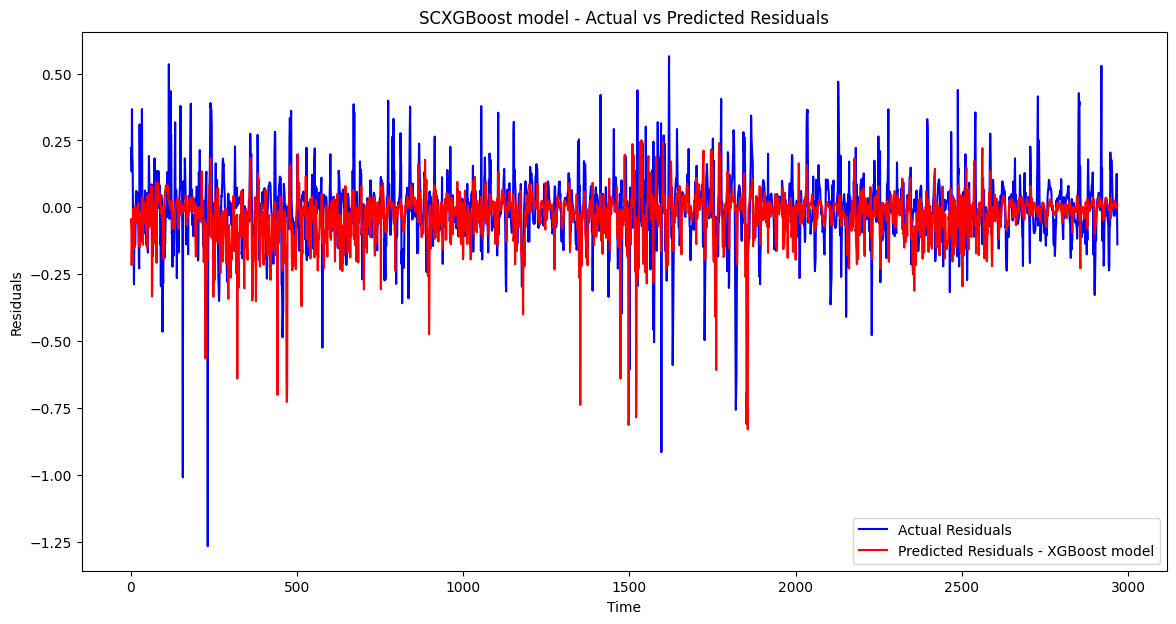

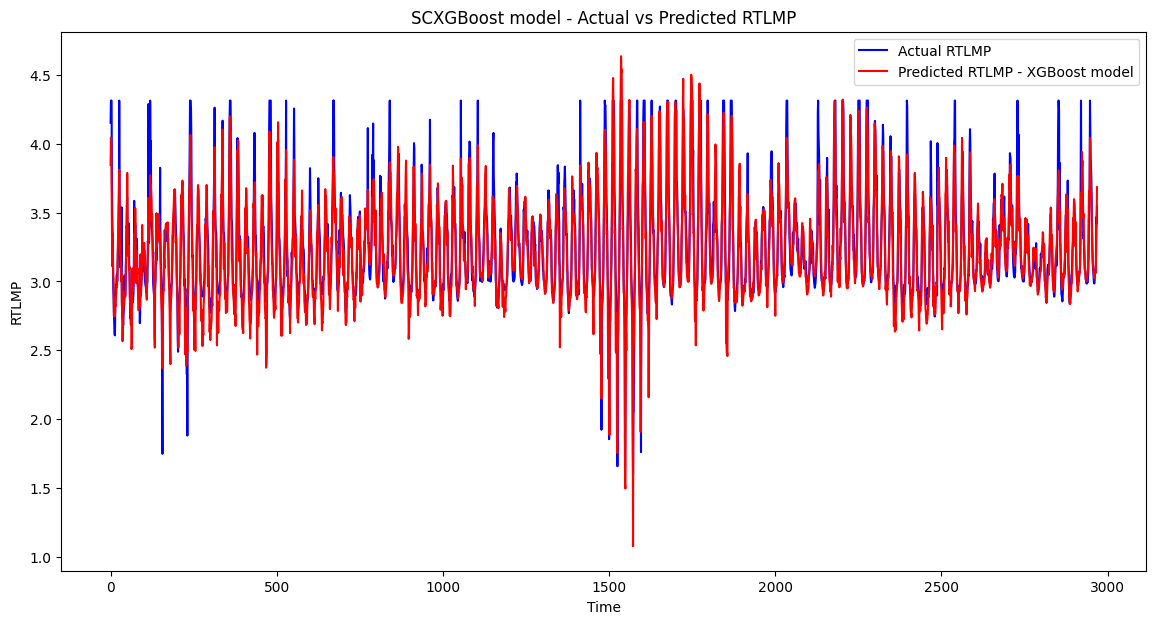

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split

# Load and preprocess the data
file_path = '/content/Assignment 3 - timeseries_data.xlsx'
df = pd.read_excel(file_path)

# Checking for missing values and replacing them with 0
df_filled = df.fillna(0)

# Remove negative values
numerical_columns = df_filled.select_dtypes(include=['number']).columns
df_filled = df_filled[(df_filled[numerical_columns] >= 0).all(axis=1)].reset_index(drop=True)

# Replace outliers using IQR method
def replace_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR
    upper_bound = Q3 + IQR
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)
    return df

columns_to_check = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']
for column in columns_to_check:
    df_filled = replace_outliers_iqr(df_filled, column)

# Feature engineering
df_filled['DATETIME'] = pd.to_datetime(df_filled['DATETIME'])
df_filled['HOUR'] = df_filled['DATETIME'].dt.hour
df_filled['MONTH'] = df_filled['DATETIME'].dt.month
df_filled['SEASON'] = df_filled['MONTH'] % 12 // 3 + 1
df_filled['SEASON'] = df_filled['SEASON'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# One-hot encoding
df_filled = pd.get_dummies(df_filled, columns=['SEASON'], prefix='SEASON')
df_filled = pd.get_dummies(df_filled, columns=['PEAKTYPE'], prefix='PEAKTYPE')
df_filled = pd.get_dummies(df_filled, columns=['MONTH'], prefix='MONTH')
df_filled = pd.get_dummies(df_filled, columns=['HOURENDING'], prefix='HOURENDING')

# Apply log transformation
df_filled[columns_to_check] = df_filled[columns_to_check].apply(lambda x: np.log(x + 1))

# Ensure no missing values after transformation
df_filled = df_filled.dropna()

# Define the target and features
target = 'HB_NORTH (RTLMP)'
columns_to_exclude = ['DATETIME', 'HB_NORTH (RTLMP)', 'MARKETDAY', 'YEAR']
all_columns = df_filled.columns.tolist()
features = [col for col in all_columns if col not in columns_to_exclude]

# Decompose the time series
def decompose_series(series, period):
    stl = STL(series, period=period)
    result = stl.fit()
    return result.trend, result.seasonal, result.resid

# Decompose the target series
trend, seasonal, resid = decompose_series(df_filled[target], period=24)

# Add the decomposed components to the dataframe
df_filled['TREND'] = trend
df_filled['SEASONAL'] = seasonal
df_filled['RESID'] = resid

# Apply log transformation to the residual component
df_filled['RESID'] = np.log(df_filled['RESID'] + 1)

# Check for invalid values after log transformation
df_filled = df_filled.replace([np.inf, -np.inf], np.nan).dropna()

# Prepare the data for XGBoost model using residuals
def create_lagged_features(df, target, lags):
    X, y = [], []
    for i in range(lags, len(df)):
        X.append(df.iloc[i-lags:i][features].values.flatten())
        y.append(df.iloc[i][target])
    return np.array(X), np.array(y)

# Create lagged features
lags = 24
X_resid, y_resid = create_lagged_features(df_filled, 'RESID', lags)

# Split the data into training and testing sets
split = int(0.8 * len(X_resid))
X_train_resid, X_test_resid, y_train_resid, y_test_resid = X_resid[:split], X_resid[split:], y_resid[:split], y_resid[split:]

# Print the description of X_train_resid and y_train_resid to debug the issue
print("X_train_resid description:\n", pd.DataFrame(X_train_resid).describe())
print("y_train_resid description:\n", pd.Series(y_train_resid).describe())

# Normalize the data
scaler = StandardScaler()
X_train_resid = scaler.fit_transform(X_train_resid)
X_test_resid = scaler.transform(X_test_resid)

# Define and train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train_resid, y_train_resid)

# Predict and evaluate the XGBoost model
y_pred_resid = xgb_model.predict(X_test_resid)

# Rescale predictions back to original scale
y_pred_resid_exp = np.exp(y_pred_resid) - 1
y_test_resid_exp = np.exp(y_test_resid) - 1

# Add trend and seasonal components back
y_pred = y_pred_resid_exp + df_filled['TREND'][split+lags:].values + df_filled['SEASONAL'][split+lags:].values
y_actual = y_test_resid_exp + df_filled['TREND'][split+lags:].values + df_filled['SEASONAL'][split+lags:].values

# Calculate metrics
def calculate_metrics(y_test, y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    data = {
        'Metric': ['MAPE', 'R2', 'MAE', 'MSE'],
        'Value': [mape, r2, mae, mse]
    }
    df_metrics = pd.DataFrame(data)
    print(df_metrics)
    return df_metrics

metrics_df = calculate_metrics(y_actual, y_pred)

# Visualization of the XGBoost model predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_resid, label='Actual Residuals', color='blue')
plt.plot(y_pred_resid, label='Predicted Residuals - XGBoost model', color='red')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('SCXGBoost model - Actual vs Predicted Residuals')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_actual, label='Actual RTLMP', color='blue')
plt.plot(y_pred, label='Predicted RTLMP - XGBoost model', color='red')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.title('SCXGBoost model - Actual vs Predicted RTLMP')
plt.legend()
plt.show()
